# Use of fast realistic simulations on GPU to extract CAD models from microtomographic data in the presence of strong CT artefacts:

# Registration of Tungsten Fibres on XCT Images

## by Franck P. Vidal, Iwan T. Mitchell and Jean-Michel L&eacute;tang

This demo aims to demonstrate how to register polygon meshes onto X-ray microtomography (micro-CT) scans of a tungsten fibre. The code relies on two building blocks:

1.  A global optimisation algorithm. We use the [CMA-ES (Covariance Matrix Adaptation Evolution Strategy)](http://cma.gforge.inria.fr/http://cma.gforge.inria.fr/). It is an evolutionary algorithm for difficult non-linear non-convex optimisation problems.
2.  A fast X-ray simulation toolkit. We use [gVirtualXRay](http://gvirtualxray.sourceforge.net/). It is a framework supporting many modern programming languages to generate realistic X-ray images from polygon meshes (triangles or tetrahedrons) on the graphics processor unit (GPU).

Below is an example of CT slice from an experiment we carried out at the [European Synchrotron Radiation Facility (ESRF)](https://www.esrf.fr/https://www.esrf.fr/).

In [1]:
from IPython.display import display
from IPython.display import Image

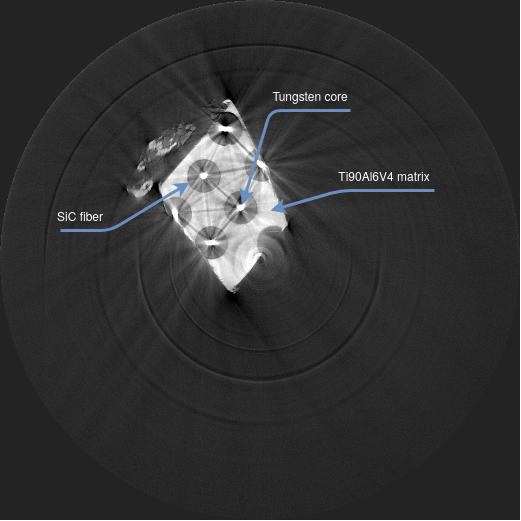

In [2]:
Image(filename="./scanned_object.png")

In a previous article, on [*Investigation of artefact sources in synchrotron microtomography via virtual X-ray imaging*](https://doi.org/10.1016/j.nimb.2005.02.003) in [Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms](https://www.sciencedirect.com/journal/nuclear-instruments-and-methods-in-physics-research-section-b-beam-interactions-with-materials-and-atoms), we demonstrated that the image above was corrupted by:

1) beam hardening depsite the use of a monochromator,
2) the response of the camera despite the point spread function (PSF) being almost a Dirac, and
3) phase contrast.

That study was published in 2005, when computer were still relatively slow. Since then, massively parallel processors such as graphics processor units (GPUs) have emerged. Using today's hardware, we will demonstrate that we can now finely tuned the virtual experiments by mathematical optimisation to register polygons meshes on XCT data. Our simulations will include beam-hardening due to polychromatism, take into account the response of the detector, and have phase contrast.

# Registration steps

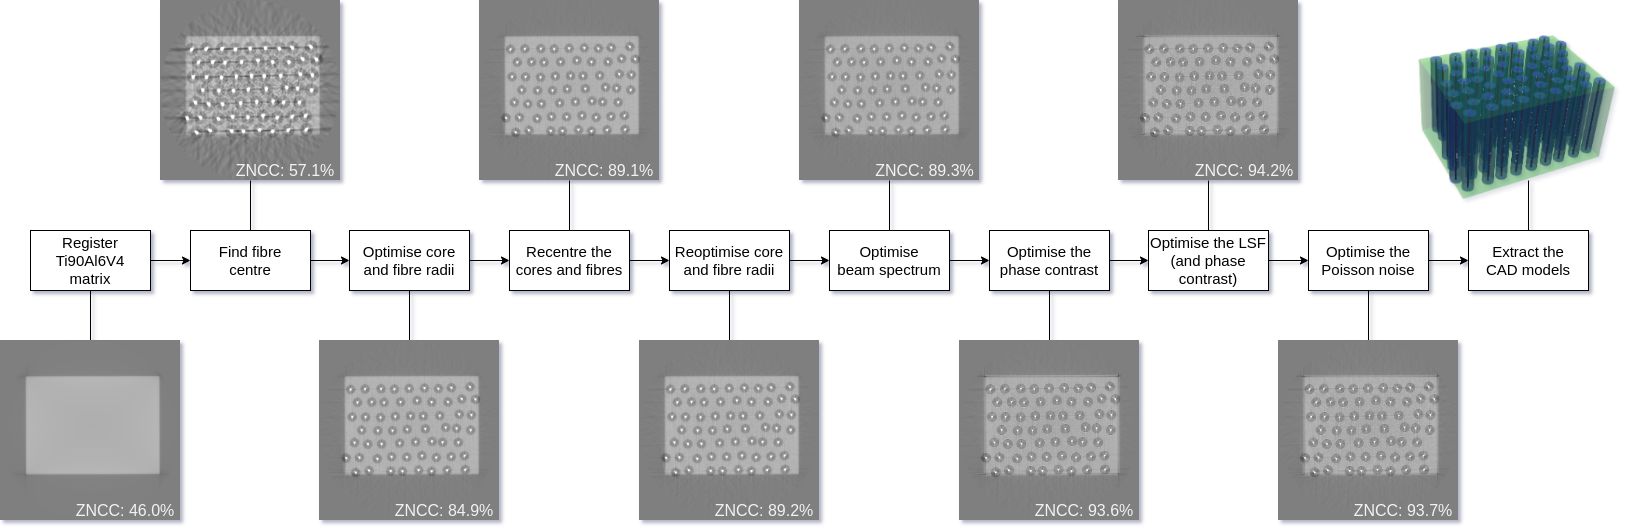

In [3]:
Image(filename="./pipeline.png")

1. Initialisation
    - [Import Python packages](#Import-packages)
    - [Global variables](#Global-variables) with values corresponding to known parameters
    - [Load the image data from the experiment at ESRF](#Load-the-image-data)
    - [Recontruct the corresponding CT data](#CT-Reconstruction)
    - [Normalise the image data](#Normalise-the-image-data)
    - [Set the X-ray simulation environment](#Set-the-X-ray-simulation-environment)
    - [LSF](#The-LSF)
    - [Find circles to identify the centre of fibres](#Find-circles-to-identify-the-centre-of-fibres)
2. [Simulate the CT acquisition](#Simulate-the-CT-acquisition)
3. [Registration of the Ti90Al6V4 matrix](#Registration-of-a-cube)
4. [Optimisation of the cores and fibres radii](#Optimisation-of-the-cores-and-fibres-radii)
5. [Recentre each core/fibre](#Recentre-each-core/fibre)
6. [Optimisation the radii after recentring](#Optimisation-the-radii-after-recentring)
7. [Optimisation of the beam spectrum](#Optimisation-of-the-beam-spectrum)
8. [Optimisation of the phase contrast and the radii](#Optimisation-of-the-phase-contrast-and-the-radii)
9. [Optimisation of the phase contrast and the LSF](#Optimisation-of-the-phase-contrast-and-the-LSF)
10. [Optimisation of the Poisson noise](#Optimisation-of-the-Poisson-noise)
11. [Results in terms of linear attenuation coefficients](#Results-in-terms-of-linear-attenuation-coefficients)

In image registration, a *moving object* is geometrically deformed so that its image matches a *target image*. 
The parameters of the deformation is controlled and iteratively tuned by an optimisation algorithm. 

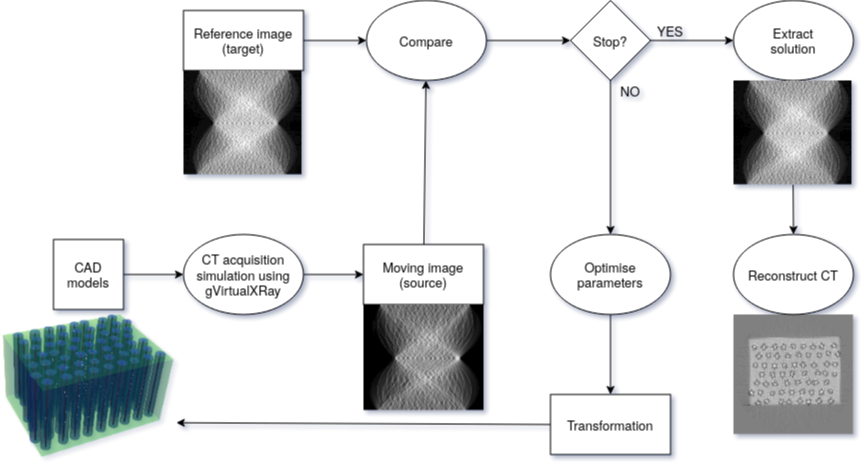

In [4]:
Image(filename="./registration.png")

In our context, the target is the sinogram provided by the experiment at ESRF. 
The moving image is created by simulation using the CAD models and [gVirtualXRay](https://sourceforge.net/projects/gvirtualxray/). 
The simulation parameters controlling the CAD models are repetitively tuned by a global optimisation algorithm until a stopping criterion is met. 
The optimisation algorithm will minimise (or maximise) a numerical value, the *objective function*. 
The comparison between the target and moving images measures how different (or similar) the two images are. 
It is performed within the objective function. 

# Import packages

We need to import a few libraries (called packages in Python). We use:
 
- `copy`: duplicating images using deepcopies;
- `glob`: retrieving file names in a directory;
- `math`: the `floor` function;
- `os`: creating a new directory;
- `sys`: retrieving the largest possible floating-point value;
- `base64`: to save a PNG screenshot of the 3D visualisation;
- `cma`: non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma));
- ([OpenCV](https://www.opencv.org/)) (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter);
- `imageio`: creating GIF files;
- `IPython.display`: display Pandas'dataframes as HTML tables;
- `matplotlib`: plotting data;
- `mpl_toolkits`: plotting 3D data (final CAD models);
- `numpy`: who doesn't use numpy?
- `pandas`: creating a DataFrame to store $\mu$ data;
- [SimpleITK](https://simpleitk.org/): image processing and saving volume data;
- `tomopy`: package for CT reconstruction;
- `scipy`: for the convolution of a 2D image by a 1D kernel;
- `skimage`: comparing the reference CT slice and the simulated one;
- `sklearn`: comparing the reference CT slice and the simulated one;
- `stl`: to import STL files (CAD models);
- `k3d`: to visualise the STL files;
- `lsf`: the line spread function to filter the X-ray images; and
- `gvxrPython3`: [gVirtualXRay](http://gvirtualxray.sourceforge.net/)'s Python wrapper to simulate X-ray images using the Beer-Lambert law on GPU.

In [5]:
%matplotlib inline

import copy
import glob
import math
import os
import sys
import base64

import cma
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import tomopy

from matplotlib import cm
from mpl_toolkits import mplot3d
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim
from skimage.util import compare_images
from sklearn.metrics import mean_absolute_error, mean_squared_error

from stl import mesh
import k3d

# plt.ioff()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# plt.rcParams['font.size'] = 15

import gvxrPython3 as gvxr

from lsf import *

In [6]:
if not os.path.exists("outputs"):
    os.makedirs("outputs");

if not os.path.exists("plots"):
    os.makedirs("plots");

# Global variables

We need some global variables:

-  `NoneType`: the type of `None`;
-  `pixel_spacing_in_micrometre`: the physical distance between the centre of two successive pixel;
-  `pixel_spacing_in_mm`: the physical distance between the centre of two successive pixel;
-  `number_of_projections`: the total number of angles in the sinogram;he total number of angles in the sinogram;
-  `angular_span_in_degrees`: the angular span covered by the sinogram;
-  `angular_step`: the angular step;
-  `theta`: the rotation angles in degrees (vertical axis of the sinogram);
-  `theta_rad`: the rotation angles in radians (vertical axis of the sinogram);
-  `roi_length`: control the size of the ROI when displayng the central fibre;
-  `value_range`: control the binning of the Laplacian kernel
-  `num_samples`: control the binning of the Laplacian kernel
-  `sigma_set`: spread of the Laplacian kernels
-  `k_set`: weight of the Laplacian kernels
-  `label_set`: label of the structures on which a Laplacian kernel is applied
-  `bias`: control the bias of the Poisson noise
-  `gain`: control the gain of the Poisson noise: control the bias of the Poisson noise
-  `scale`: control the scale of the Poisson noise: control the bias of the Poisson noise
-  `use_normalisation`: use or do not use zero-mean, unit-variance normalisation in the objective functions;
-  `use_sinogram`: compute the objective functions on the sinogram or flat-field;
-  `metrics_type`: type of image comparison used in the objective functions;
-  `fibre_radius`: radius of the SiC fibres in um
-  `core_radius`: radius of the W fibres in um

In [7]:
NoneType = type(None);
pixel_spacing_in_micrometre = 1.9;
pixel_spacing_in_mm = pixel_spacing_in_micrometre * 1e-3;
number_of_projections = 900;
angular_span_in_degrees = 180.0;
angular_step = angular_span_in_degrees / number_of_projections;
theta = np.linspace(0.,
                    angular_span_in_degrees,
                    number_of_projections,
                    endpoint=False);
theta_rad = theta / 180.0 * math.pi;

roi_length = 60;

value_range = 6;
num_samples = 15;

sigma_set = None;
k_set = None;
label_set = None;

bias = None;
gain = None;
scale = None;

use_normalisation = True;
use_sinogram = True;

metrics_type = "RMSE";

fibre_radius = 140 / 2;  # um
core_radius = 30 / 2;  # um

# Load the image data

Load and display the reference projections from a raw binary file, i.e. the target of the registration.

In [8]:
# Target of the registration
reference_normalised_projections = np.fromfile("sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [
    number_of_projections,
    int(reference_normalised_projections.shape[0] / number_of_projections)
];

We define a function to save raw images in the MHA format:

In [9]:
def saveMHA(fname, image, spacing):
    """
    save the image into a file.

    :param str fname: the filename
    :param 2D_image image: the image to save
    :param [flt, flt, flt] spacing: the space between two successive voxels along the 3 direction
    """

    volume = sitk.GetImageFromArray(image);
    volume.SetSpacing(spacing);
    sitk.WriteImage(volume, fname, useCompression=True);

The reference projections in a MHA file 

In [10]:
saveMHA('outputs/reference_normalised_projections.mha', reference_normalised_projections, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

Display the reference projections using Matplotlib

In the literature, a projection is often modelled using the polychromatic version of the Beer-Lambert law:
$$\mathbf{I}(x,y) = \sum_i \mathbf{R}_i \, \mathbf{N}_i \; \exp\left({-\sum_j \mu_j(E_i) \; \mathbf{d}_j(x,y)}\right)$$

- $\mathbf{I}(x,y)$ the value of the raw X-ray projection at pixel location $(x,y)$, and with the sample and with the X-ray beam turned on;
- $i$ the $i$-th energy channel in the beam spectrum;   
- $E_i$ the energy in eV; 
- $\mathbf{R}_i$ and $\mathbf{N}_i$ the detector response and the number of photons at that energy respectively;
- $j$ the $j$-th material being scanned, $\mu_j(E_i)$ its linear attenuation coefficient at energy $E_i$, and
- $\mathbf{d}_j(x,y)$ path length in cm$^{-1}$ of the ray crossing the $j$-th material from the X-ray source to pixel $(x,y)$.


Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
$$\mathbf{Proj} = \frac{\mathbf{I} - \mathbf{D}}{\mathbf{F} - \mathbf{D}}$$
$\mathbf{F}$ (full fields) and $\mathbf{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. Note that with an ideal detector ($\mathbf{R}_i=E_i$), pixels of $\mathbf{D}$ are null, and pixels of $\mathbf{F}$ are equal to $\sum_i E_i \; \mathbf{N}_i$. 

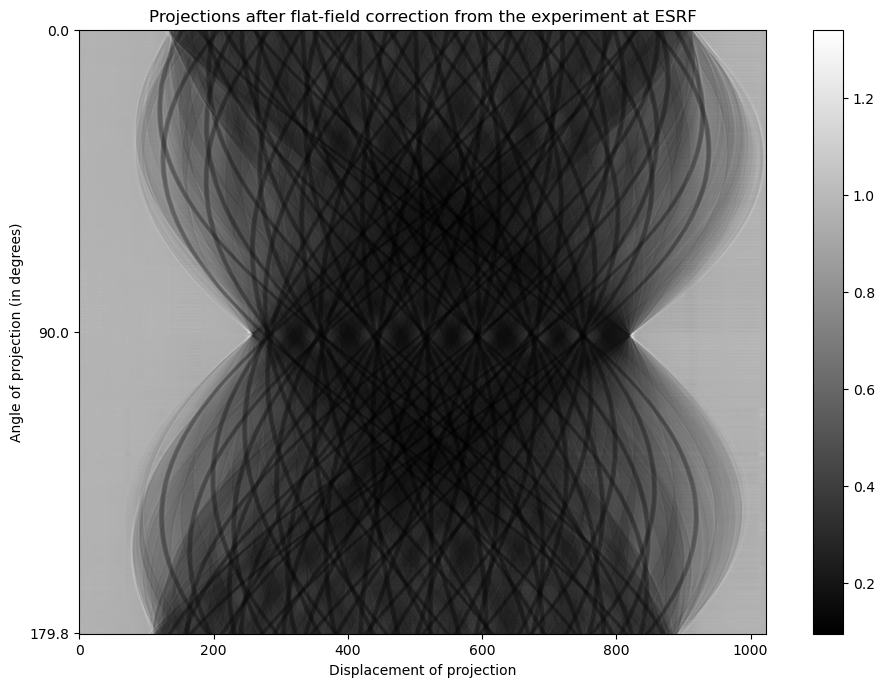

In [11]:
labels = [theta[0], theta[reference_normalised_projections.shape[0] // 2], theta[-1]];
tics = [
    0,
    reference_normalised_projections.shape[0] // 2,
    reference_normalised_projections.shape[0]-1
];
fig = plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Projections after flat-field correction from the experiment at ESRF");
fig.colorbar(imgplot);
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.pdf')
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.png')

`reference_normalised_projections` (the figure above) corresponds to the data loaded from the binary file. It corresponds to $\mathbf{Proj}$, i.e. the flat-field correction has already been performed. 

We can see that when the primary spectrum is not monochromatic the measurement is the sum of several attenuation laws. We could however compute the effective monochromatic attenuation that would give the same measurement:
$$    \mathbf{I}(x,y) = \mathbf{I}_0(x,y) \; \exp\left({-\sum_j \mu_j(E_{\mathrm{eff}}) \; \mathbf{d}_j(x,y)}\right)$$
    
with $\mathbf{I}_0(x,y) = \sum_i \mathbf{R}_i \, \mathbf{N}_i$, and where $E_{\mathrm{eff}}$ corresponds to the monochromatic energy that would give the same attenuation than
the one measured. We are now able to linearise the transmission tomography data, namely $\mathbf{Proj}$, and we get the sinogram:
$$\textbf{Sino}=-\ln\left(\textbf{Proj}\right)$$

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [12]:
def computeSinogramFromFlatField(normalised_projections):
    """
    This function apply the minus log normalisation
    on the projections that bave been corrected with the flat-field method.

    :param 2D_image normalised_projections: The projections after flat-field corrections
    :return the sinogram.
    """

    # Create a temporary image to hold the sinogram
    simulated_sinogram = copy.deepcopy(normalised_projections);

    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000001
    simulated_sinogram[simulated_sinogram < threshold] = threshold;

    # Apply the minus log normalisation
    simulated_sinogram = -np.log(simulated_sinogram);

    # Rescale the data taking into account the pixel size
    simulated_sinogram /= pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    # Return the new image
    return simulated_sinogram;

Compute the sinogram from the flat-field data

In [13]:
reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

Save the corresponding image

In [14]:
saveMHA('outputs/reference_sinogram.mha', reference_sinogram, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

Display the sinogram using Matplotlib

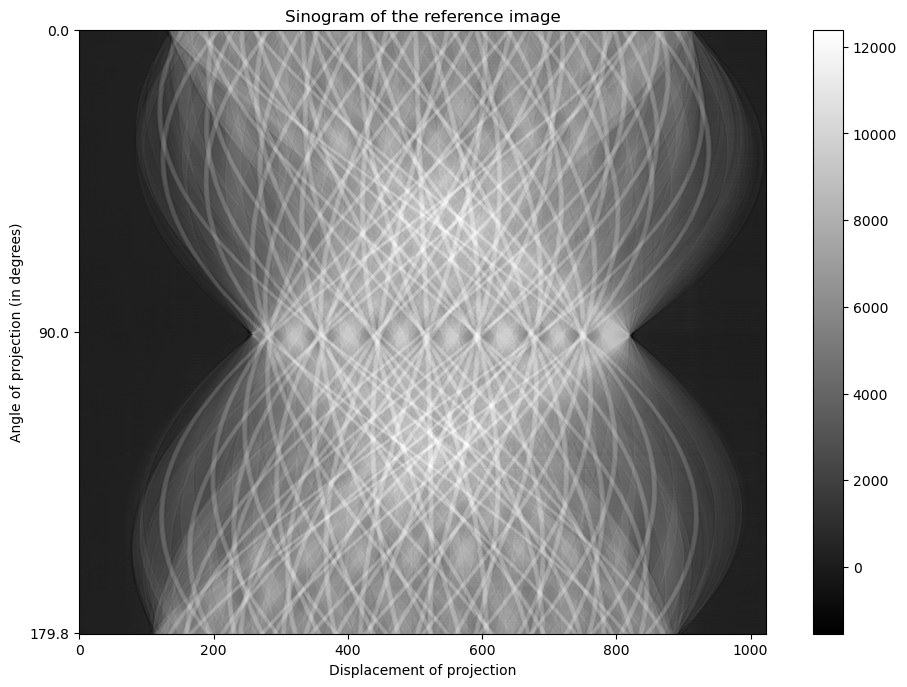

In [15]:
labels=[theta[0], theta[reference_sinogram.shape[0] // 2], theta[-1]];
tics=[0, reference_sinogram.shape[0] // 2, reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);
plt.savefig('plots/Sinogram_reference_image.pdf');
plt.savefig('plots/Sinogram_reference_image.png');

# CT reconstruction

Now we got a sinogram, we can reconstruct the CT slice. As we used a synchrotron, we can assume we have a parallel source. It means we can use a FBP rather than the FDK algorithm. In fact we use the gridrec algorithm, which is much faster:

Dowd BA, Campbell GH, Marr RB, Nagarkar VV, Tipnis SV, Axe L, and Siddons DP. [Developments in synchrotron x-ray computed microtomography at the national synchrotron light source](https://doi.org/10.1117/12.363725). In Proc. SPIE, volume 3772, 224–236. 1999.

In [16]:
reference_sinogram.shape = [
    reference_sinogram.shape[0],
    1,
    reference_sinogram.shape[1]
];

rot_center = int(reference_sinogram.shape[2]/2);

reference_CT = tomopy.recon(reference_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp')[0];

Save the reconstruction in a MHA file

In [17]:
saveMHA('outputs/reference_CT.mha', reference_CT, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

Plot the CT slice using Matplotlib

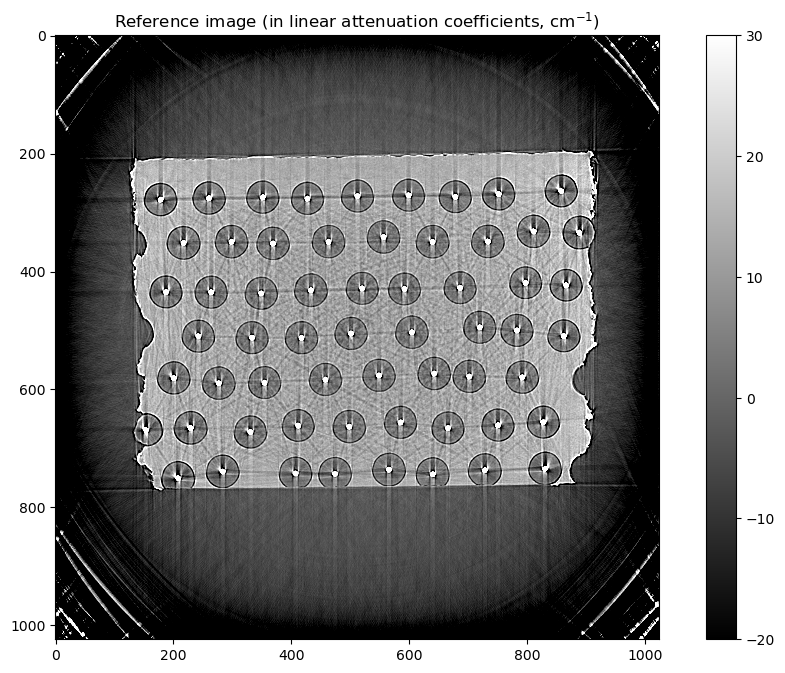

In [18]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=30, vmin=-20)
imgplot = plt.imshow(reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");
plt.savefig('plots/reference_image_in_mu.pdf');
plt.savefig('plots/reference_image_in_mu.png');

# Normalise the image data

Zero-mean, unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (or Z-score Normalisation) in machine learning. It is computed as follows:

$$\mathbf{m}_o=\frac{\mathbf{m}-\bar{m}}{\sigma_m}$$

where $\mathbf{m}_o$ is the image after normalisation of Image $\mathbf{m}$, $\bar{m}$ is the average pixel value of Image $\mathbf{m}$, and $\sigma_m$ its standard deviation.
After normalisation, the average pixel value is null and the standard deviation of pixel values is equal to one.

We define a function to apply this:

In [19]:
def standardisation(I):
    image = copy.deepcopy(I);

    # Sometimes the CT reconstruction algorithm create NaN on
    # the top and right borders, we filter them out using
    # a median filter ignoring NaN
    nan_index = np.argwhere(np.isnan(image));
    if nan_index.shape[0]:
        temp = np.pad(image, 1, "edge");

        for index in nan_index:
            roi = temp[index[0]-1+1:index[0]+1+2, index[1]-1+1:index[1]+1+2];
            image[index[0], index[1]] = np.nanmedian(roi);

    return (image - image.mean()) / image.std();


Normalise the reference sinogram and CT slice

In [20]:
normalised_reference_sinogram = standardisation(reference_sinogram);
normalised_reference_CT       = standardisation(reference_CT);

# Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [21]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

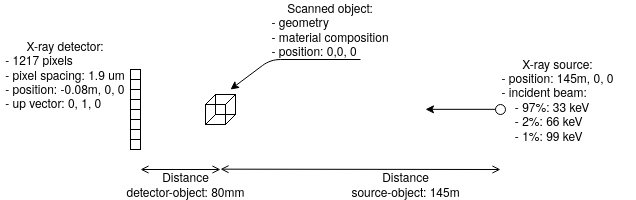

In [22]:
Image(filename="./3d_scene.png")

In [23]:
detector_width_in_pixels = reference_sinogram.shape[2];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(pixel_spacing_in_micrometre, pixel_spacing_in_micrometre, "micrometer");

And the source parameters (beam shape, source position)

In [24]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "m");
gvxr.usePointSource();
# gvxr.useParallelBeam();

The beam spectrum. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [25]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

Plot the beam spectrum using Matplotlib

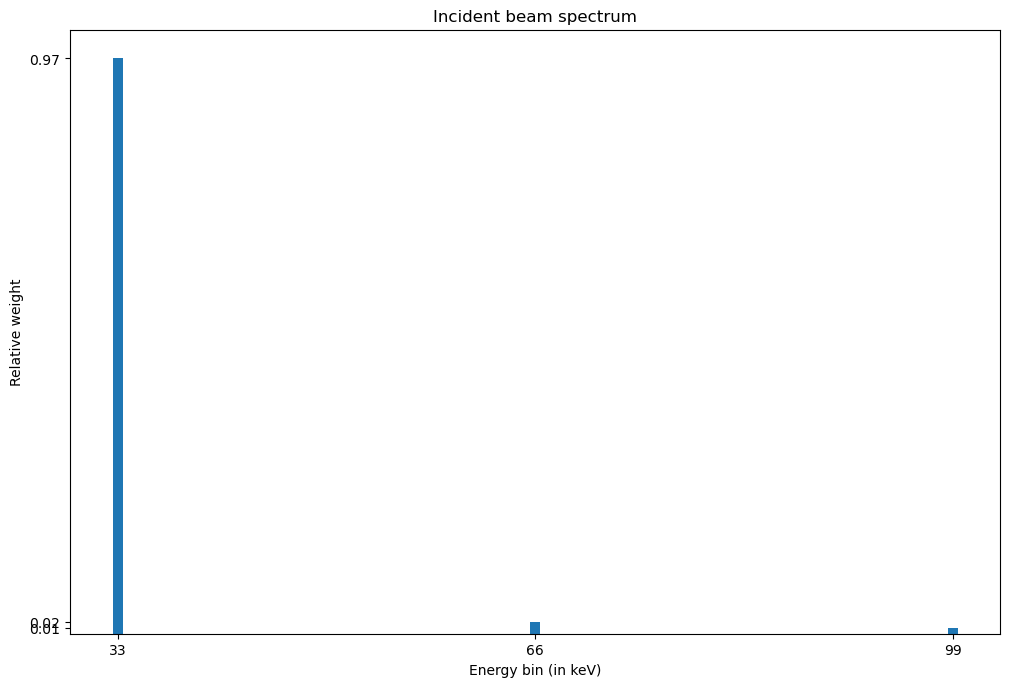

In [26]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);
plt.savefig('plots/beam_spectrum.pdf');
plt.savefig('plots/beam_spectrum.png');

The material properties (chemical composition and density)

In [27]:
fibre_material = [("Si", 0.5), ("C", 0.5)];
fibre_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_density = 4.42 # g/cm3

# The LSF

In a previous study, we experimentally measured the impulse response of the detector as the line spread function (LSF):

F.P. Vidal, J.M. Létang, G. Peix, P. Cloetens, Investigation of artefact sources in synchrotron microtomography via virtual X-ray imaging, *Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms*, Volume 234, Issue 3, 2005, Pages 333-348, ISSN 0168-583X, DOI [10.1016/j.nimb.2005.02.003](10.1016/j.nimb.2005.02.003).

We use this model during the initial steps of the registration. The LSF model will be tuned in one of the final steps of the registration.

In [28]:
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41)/lsf(0);
lsf_kernel/=lsf_kernel.sum();

Plot the LSF using Matplotlib

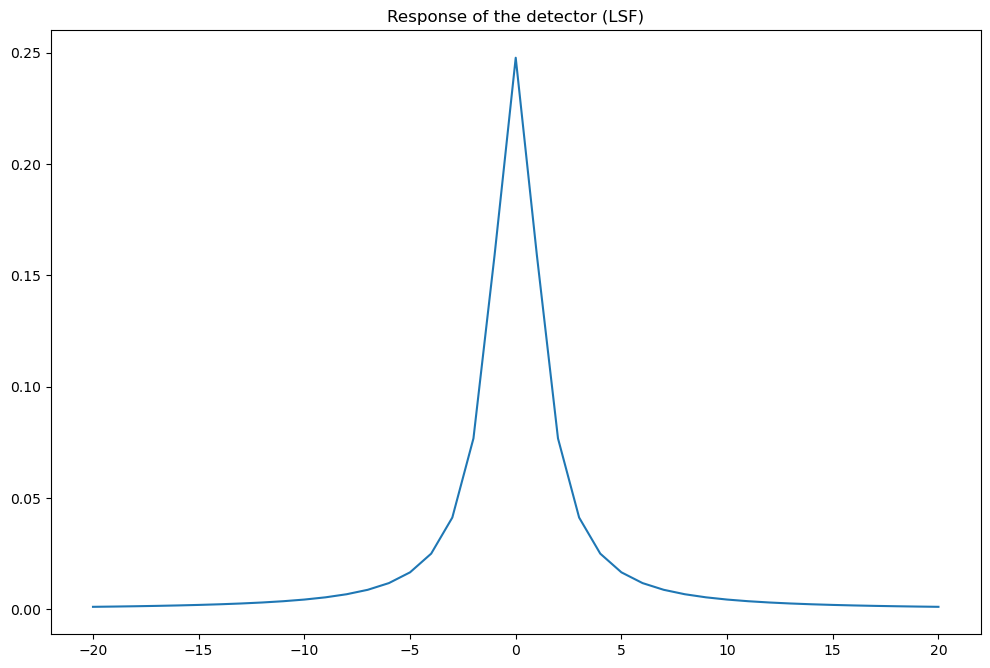

In [29]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, lsf_kernel);
plt.savefig('plots/LSF.pdf');
plt.savefig('plots/LSF.png');

# Find circles to identify the centre of fibres

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT. We blur it using a bilateral filter (an edge-preserving smoothing filter).

## Convert the image to UINT

We first create a function to convert images in floating point numbers into UINT.

In [30]:
def float2uint8(anImage, min_threshold = None, max_threshold = None):
    
    uchar_image = copy.deepcopy(anImage);

    if isinstance(min_threshold, NoneType):
        min_threshold = np.min(uchar_image);

    if isinstance(max_threshold, NoneType):
        max_threshold = np.max(uchar_image);
        
    uchar_image[uchar_image < min_threshold] = min_threshold;
    uchar_image[uchar_image > max_threshold] = max_threshold;

    uchar_image -= min_threshold;
    uchar_image /= max_threshold - min_threshold;
    uchar_image *= 255;
    
    return uchar_image.astype(np.uint8);

We blur the CT scan using a bilateral filter. It preserves edges.

In [31]:
uint8_reference_CT = float2uint8(reference_CT, 0, 300);
blurred_reference_CT = cv2.bilateralFilter(uint8_reference_CT, 9, 75, 75);

saveMHA('outputs/blurred_reference_CT.mha', blurred_reference_CT, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

## Apply the Hough transform

As the fibres and the cores correspond to circles in the CT images, the obvious technique to try is the Hough Circle Transform (HCT). It is a feature extraction technique used in image analysis that can output a list of circles (centres and radii). 

In [32]:
circles = cv2.HoughCircles(blurred_reference_CT, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=150, param2=5, minRadius=5, maxRadius=15);

## Overlay the detected circles on the top of the image

In [33]:
cimg = cv2.cvtColor(float2uint8(reference_CT, 0, 50), cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2);
    
    # draw the center of the circle
    cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3);

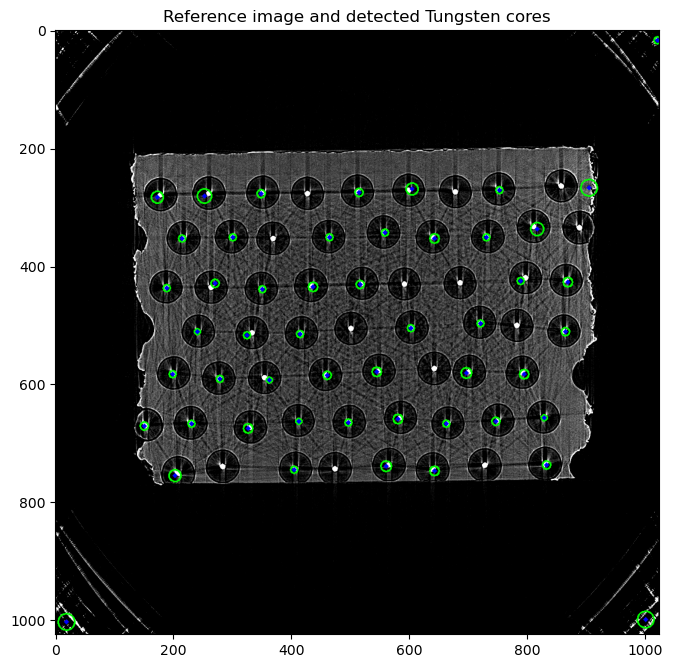

In [34]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_Hough_transform.pdf');
plt.savefig('plots/fibre_detection_using_Hough_transform.png');

13 fibres were missed and many centres were misplaced. Controlling the meta-parameters of the algorithm can be difficult to employ in a fully-automatic registration framework. We will use another technique to register the fibres, the popular Otsu's method. It creates a histogram and uses a heuristic to determine a threshold value.

In [35]:
# Convert the numpy array in float32 into uint, then into a SITK image
volume = sitk.GetImageFromArray(blurred_reference_CT);
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 91.0


In [36]:
sitk.WriteImage(seg, "outputs/cores_segmentation.mha", useCompression=True);

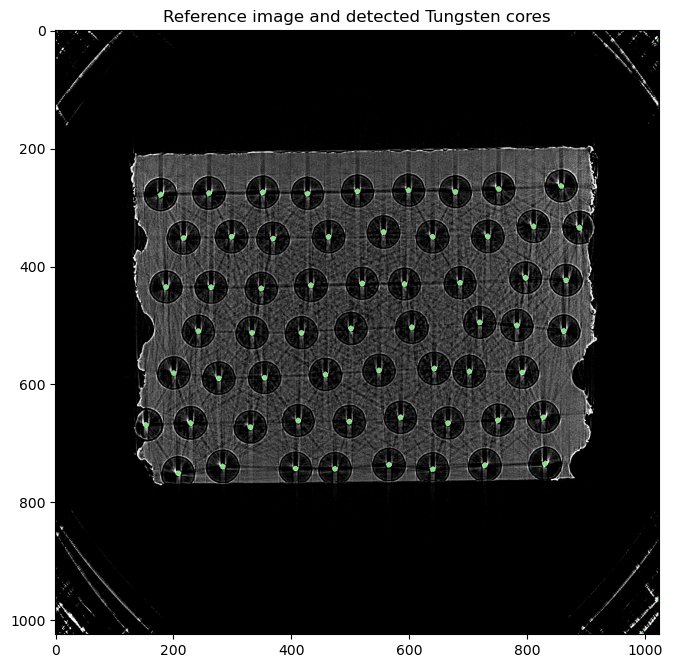

In [37]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, seg)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method.png');

## Clean up

In [38]:
# Clean-up using mathematical morphology
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(seg, [3, 3, 3])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [3, 3, 3])

In [39]:
sitk.WriteImage(cleaned_thresh_img, "outputs/cores_cleaned_segmentation.mha", useCompression=True);

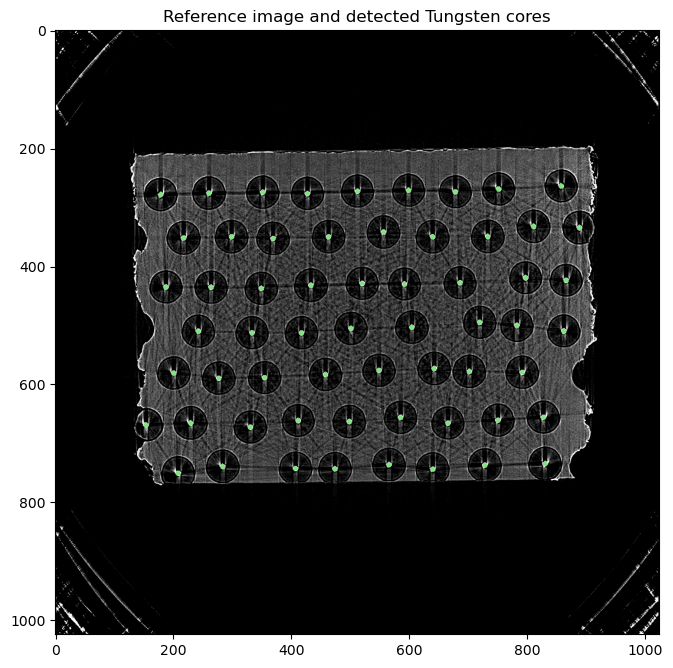

In [40]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, cleaned_thresh_img)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.png');

## Mark each potential tungsten core with unique label

Each distinct tungsten core is assigned a unique label, i.e. a unique pixel intensity

In [41]:
core_labels = sitk.ConnectedComponent(cleaned_thresh_img);

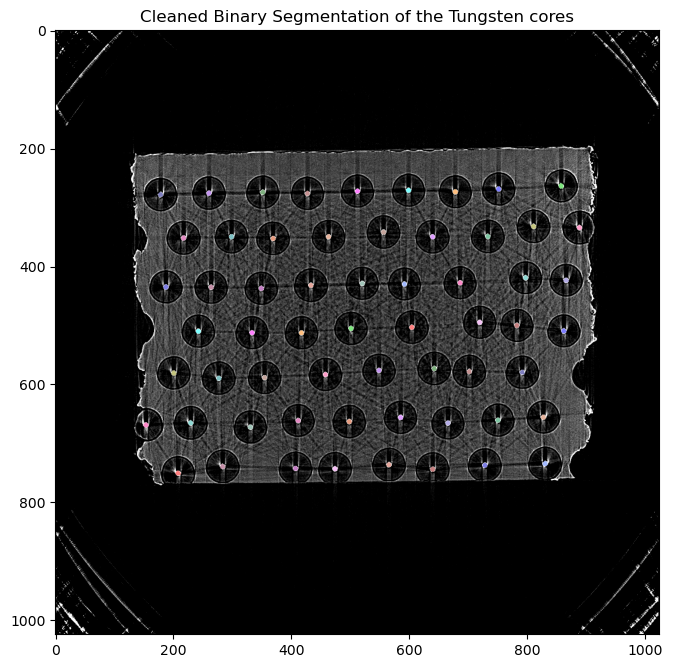

In [42]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, core_labels)));
plt.title("Cleaned Binary Segmentation of the Tungsten cores");
plt.savefig('plots/fibre_detection_with_label_overlay.pdf');
plt.savefig('plots/fibre_detection_with_label_overlay.png');

## Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects. For each labelled tungsten core, we extract the centroid. Note that sizes and positions are given in millimetres.

In [43]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(core_labels)

In [44]:
centroid_set = [];

for i in shape_stats.GetLabels():
    centroid_set.append(cleaned_thresh_img.TransformPhysicalPointToIndex(shape_stats.GetCentroid(i)));

We now have a list of the centres of all the fibres that can be used as a parameter of the function below to create the cylinders corresponding to the cores and the fibres. 
For each core, a cylinder is creatd and translated:
```python
        gvxr.emptyMesh("core_"  + str(i));
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");
        gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");
```
For each fibre, another cylinder is created and translated:
```python
        gvxr.emptyMesh("fibre_"  + str(i));
        gvxr.makeCylinder("fibre_"  + str(i), number_of_sectors, 815.0,  fibre_radius, "micrometer");
        gvxr.translateNode("fibre_"  + str(i), y, 0.0, x, "micrometer");
```
The fibre's cylinder is hollowed to make space for its core:
```python
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));
```

In [45]:
def setFibres(aCentroidSet):
    """This function loads a cylinders in the GPU memory.
    Some are hollow and represent the fibres, some are not and
    correspond to the cores.

    :param array aCentroidSet: a list of cylinder centres.
    """

    global core_radius;
    global fibre_radius;

    # Create empty geometries
    gvxr.emptyMesh("fibre");
    gvxr.emptyMesh("core");

    # Number of sectors to approximate cylinders with triangle meshes
    # It controls the accuracy of the meshes.
    number_of_sectors = 100;

    # Process all the centres from the input list
    for i, cyl in enumerate(aCentroidSet):

        # Convert the centre position from 2D image coordinates in 3D world coordinates
        x = pixel_spacing_in_micrometre * -(cyl[0] - reference_CT.shape[1] / 2 + 0.5);
        y = pixel_spacing_in_micrometre * (cyl[1] - reference_CT.shape[0] / 2 + 0.5);

        # Create empty geometries (is it needed?)
        gvxr.emptyMesh("fibre_" + str(i));
        gvxr.emptyMesh("core_" + str(i));

        # Create the two corresponding cylinders (fibre and core)
        gvxr.makeCylinder("fibre_" + str(i), number_of_sectors, 815.0, fibre_radius, "micrometer");
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

        # Translate the two cylinders to the position of their centre
        gvxr.translateNode("fibre_" + str(i), y, 0.0, x, "micrometer");
        gvxr.translateNode("core_" + str(i), y, 0.0, x, "micrometer");

        # Apply the local transformation matrix (so that we could save the corresponding STL files)
        gvxr.applyCurrentLocalTransformation("fibre_" + str(i));
        gvxr.applyCurrentLocalTransformation("core_" + str(i));

        # Subtract the fibre from the matrix
        gvxr.subtractMesh("matrix", "fibre_" + str(i));

        # Subtract the core from the fibre
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));

        # Save the corresponding STL files
        # gvxr.saveSTLfile("fibre_" + str(i), "Tutorial2/outputs/fibre_" + str(i) + ".stl");
        # gvxr.saveSTLfile("core_" + str(i),  "Tutorial2/outputs/core_"  + str(i) + ".stl");

        # Add the mesh of the current fibre to the overall fibre mesh
        gvxr.addMesh("fibre", "fibre_" + str(i));

        # Add the mesh of the current core to the overall core mesh
        gvxr.addMesh("core", "core_"  + str(i));

    # Set the mesh colours (for the interactive visualisation)
    gvxr.setColor("fibre", 1.0, 0.0, 0.0, 1.0);
    gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

    # Set the fibre's material properties
    # gvxr.setLinearAttenuationCoefficient("fibre", fibre_mu, "cm-1");
    gvxr.setCompound("fibre", "SiC");
    gvxr.setDensity("fibre", fibre_density, "g/cm3");

    # Set the core's material properties
    # gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
    gvxr.setElement("core", "W");

    # Add the fibres and cores to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fibre");

# Registration of a cube

We define a function to create the polygon mesh of the Ti90Al6V4 matrix.

In [46]:
def setMatrix(apGeneSet):
    """This function loads a cube in the GPU memory. The cube represents
    the Ti90Al6V4 matrix.

    apGeneSet[0] is a number between -0.5 and 0.5, related to the translation vector (X component) of the cube. It can be interpreted as a percentage of the detector width.
    apGeneSet[1] is the same as apGeneSet[0], but related to the Y component of the translation vector.
    apGeneSet[2] is a number between -0.5 and 0.5, related to the rotation angle in degrees
    apGeneSet[3] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of the detector width.
    apGeneSet[4] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of apGeneSet[3].
    """

    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph();

    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 180.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);

    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * w;
    gvxr.scaleNode("matrix", w, 815, h);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Set the matrix's material properties
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("matrix");

## Simulate the CT acquisition

There are 7 successive steps to simulate the XCT data acquisition:

1. Set the fibre and cores geometries and material properties (Step 45)
2. Set the matrix geometry and material properties (Step 46)
3. Simulate the raw projections for each angle:
   - Without phase contrast (Line 9 of Step 49), or
   - With phase contrast (Lines 12-55 of Step 49)
4. Apply the LSF (Lines 57-60 of Step 49)
5. Apply the flat-field correction (Line 63 of Step 49)
6. Add Poison noise (Lines 67-76 of Step 49)(Lines 12-55 of Step 49)
7. Apply the minus log normalisation to compute the sinogram (Line 79 of Step 49)

Compute the raw projections and save the data. For this  purpose, we define a new function.

In [47]:
def tomographyAcquisition():
    """
    This function simulate a CT acquisition.

    :return the raw projections in keV
    """

    # Crete a new array to save every projection in default unit of energy
    raw_projections = [];

    # For each angle, simulate a projection
    for angle_id in range(0, number_of_projections):

        # Reset the transformation matrix and rotate the scnned object
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        xray_image = np.array(gvxr.computeXRayImage());

        # Add the projection
        raw_projections.append(xray_image);

    # Convert from the default unit of energy to keV
    raw_projections = np.array(raw_projections);
    raw_projections_in_keV = raw_projections / gvxr.getUnitOfEnergy("keV");

    return raw_projections_in_keV;

## Flat-filed correction

Because the data suffers from a fixed-pattern noise in X-ray imaging in
actual experiments, it is necessary to perform the flat-field correction of
the raw projections using:

$$\mathbf{Proj} = \frac{\mathbf{I} - \mathbf{D}}{\mathbf{F} - \mathbf{D}}$$
$\mathbf{F}$ (full fields) and $\mathbf{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively.

Note that in our example, `raw_projections_in_keV` ($\mathbf{I}$), `flat_field_image` ($\mathbf{F}$) and `dark_field_image` ($\mathbf{D}$) are in keV whereas `corrected_projections` ($\mathbf{Proj}$) does not have any unit:

$$0 \leq \mathbf{I} \leq  \sum_E N_0(E) \times E\\0 \leq \mathbf{Proj} \leq 1$$

We define a new function to compute the flat-field correction.

In [48]:
def flatFieldCorrection(raw_projections_in_keV):
    """
    This function applies the flat-field correction on raw projections.

    :param 2D_image raw_projections_in_keV: the raw X-ray projections in keV
    :return the projections (raw_projections_in_keV) after flat-field correction
    """

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections_in_keV.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);

    return corrected_projections;

The function below is used to simulate a sinogram acquisition. Phase contrast in the projections can be taken into account or not. Also, Poisson noise can be added.

In [49]:
def simulateSinogram(sigma_set=None, k_set=None, name_set=None):

    global lsf_kernel;

    # Do not simulate the phase contrast using a Laplacian
    if isinstance(sigma_set, NoneType) or isinstance(k_set, NoneType) or isinstance(name_set, NoneType):

        # Get the raw projections in keV
        raw_projections_in_keV = tomographyAcquisition();

    # Simulate the phase contrast using a Laplacian
    else:

        # Create the convolution filter
        pixel_range = np.linspace(-value_range, value_range, num=int(num_samples), endpoint=True)
        laplacian_kernels = {};

        # Store the L-buffers
        L_buffer_set = {};

        # Look at all the children of the root node
        for label in ["core", "fibre", "matrix"]:
            # Get its L-buffer
            L_buffer_set[label] = getLBuffer(label);

        # Create blank images
        raw_projections_in_keV = np.zeros(L_buffer_set["fibre"].shape);
        phase_contrast_image = np.zeros(L_buffer_set["fibre"].shape);

        for label, k, sigma in zip(name_set, k_set, sigma_set):
            laplacian_kernels[label] = k * laplacian(pixel_range, sigma);

            for z in range(phase_contrast_image.shape[0]):
                for y in range(phase_contrast_image.shape[1]):
                    phase_contrast_image[z][y] += ndimage.convolve((L_buffer_set[label])[z][y], laplacian_kernels[label], mode='wrap');

        for energy, photon_count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):

            # Create a blank image
            attenuation = np.zeros(L_buffer_set["fibre"].shape);

            # Look at all the children of the root node
            # for label in ["core", "fibre", "matrix"]:
            for label in ["core", "fibre", "matrix"]:
                # Get mu for this object for this energy
                mu = gvxr.getLinearAttenuationCoefficient(label, energy, "keV");

                # Compute sum mu * x
                attenuation += L_buffer_set[label] * mu;

            # Store the projection for this energy channel
            raw_projections_in_keV += energy * photon_count * np.exp(-attenuation);

        # Apply the phase contrast
        raw_projections_in_keV -= phase_contrast_image;

    # Apply the LSF line by line
    for z in range(raw_projections_in_keV.shape[0]):
        for y in range(raw_projections_in_keV.shape[1]):
            raw_projections_in_keV[z][y] = ndimage.convolve(raw_projections_in_keV[z][y], lsf_kernel, mode='wrap');

    # Flat-field correction
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    normalised_projections[normalised_projections < 0] = 0;

    # Add noise
    if not isinstance(bias, NoneType) and not isinstance(gain, NoneType) and not isinstance(scale, NoneType):

        map = (normalised_projections + (bias + 1)) * gain;
        temp = np.random.poisson(map).astype(float);
        temp /= gain;
        temp -= bias + 1;

        # Noise map
        noise_map = (normalised_projections - temp) * scale;
        normalised_projections += noise_map;

    # Linearise
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);

    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

The function below is used quantify the differences between two images. It is used in the objective function.

In [50]:
def metrics(ref, test):

    normalised_ref = ref.flatten();
    normalised_test = test.flatten();

    if use_normalisation or metrics_type == "ZNCC":
        normalised_ref = standardisation(normalised_ref);
        normalised_test = standardisation(normalised_test);

    # Mean absolute error
    if metrics_type == "MAE":
        return mean_absolute_error(normalised_ref, normalised_test);
    # RMSE
    elif metrics_type == "RMSE":
        return math.sqrt(mean_squared_error(normalised_ref, normalised_test));
    # Mean relative error
    elif metrics_type == "MRE" or metrics_type == "MAPE":

        # Prevent division by zero
        denominator = np.abs(np.subtract(normalised_ref, normalised_test)) + 1e-6;
        divisor = np.abs(normalised_ref) + 1e-6;

        return np.mean(np.divide(denominator, divisor));
    elif metrics_type == "SSIM" or metrics_type == "DSSIM":
        normalised_ref.shape = [900, 1024];
        normalised_test.shape = [900, 1024];
        return (1.0 - ssim(normalised_ref, normalised_test,
                  data_range=normalised_ref.max() - normalised_ref.min())) / 2.0;
    elif metrics_type == "ZNCC":
        return (1.0 - np.mean(np.multiply(normalised_ref, normalised_test))) / 2.0;
    else:
        raise "Unknown metrics";

The function below is the objective function used to register the matrix.

In [51]:
def fitnessFunctionCube(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;

    global reference_sinogram;
    global centroid_set;
    global use_fibres;

    global core_radius;
    global fibre_radius;

    # Load the matrix geometrical properties from x
    setMatrix(x);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;

        gvxr.saveSTLfile("matrix", "outputs/matrix_" + str(best_fitness_id) + ".stl");

        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];

        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [52]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/cube.dat"):
    matrix_geometry_parameters = np.loadtxt("outputs/cube.dat");
# Perform the registration using CMA-ES
else:
    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "cube_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = [5*[-0.5], 5*[0.5]];

    es = cma.CMAEvolutionStrategy([0.0, 0.0, 0.0, 0.256835938, 0.232903226], 0.5, opts);
    es.optimize(fitnessFunctionCube);

    matrix_geometry_parameters = copy.deepcopy(es.result.xbest);
    np.savetxt("outputs/cube.dat", matrix_geometry_parameters, header='x,y,rotation_angle,w,h');
    
    # Release memory
    del es;

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=723641, Wed Aug 11 17:07:25 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.094954737592163e+00 1.0e+00 4.27e-01  4e-01  4e-01 0:04.7
    2     16 7.847555640186077e-01 1.2e+00 3.57e-01  3e-01  4e-01 0:08.1
    3     24 1.115136747209895e+00 1.4e+00 3.64e-01  3e-01  4e-01 0:11.3
    4     32 1.231106093423999e+00 1.4e+00 4.03e-01  3e-01  5e-01 0:14.6
    6     48 8.833336352985762e-01 1.8e+00 3.71e-01  3e-01  4e-01 0:21.0
    8     64 1.056062914736723e+00 1.9e+00 2.99e-01  2e-01  3e-01 0:27.2
   10     80 9.854065226044122e-01 2.3e+00 2.59e-01  1e-01  3e-01 0:33.3
   13    104 6.638930606599894e-01 2.2e+00 1.87e-01  1e-01  2e-01 0:42.7
   16    128 5.974250371930541e-01 2.5e+00 1.49e-01  7e-02  1e-01 0:52.6
   19    152 6.176599538384471e-01 2.2e+00 1.11e-01  5e-02  9e-02 1:02.1
   22    176 5.260765226564615e-01 2.5e+00 1.66e-01  7e-02  2e-01 1:12.3
   26    208 3.408282972258348e-01 

## Apply the result of the registration

In [53]:
# Save the result
setMatrix(matrix_geometry_parameters);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");

# Translation vector
x = matrix_geometry_parameters[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
y = matrix_geometry_parameters[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;

# Rotation angle
rotation_angle_in_degrees = (matrix_geometry_parameters[2] + 0.5) * 180.0;

# Scaling factors
w = (matrix_geometry_parameters[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
h = (matrix_geometry_parameters[4] + 0.5) * w;

print("Matrix");
print("\tposition:", x, y, "um");
print("\trotation:", rotation_angle_in_degrees, "deg");
print("\tsize:", w, h, "um");

Matrix
	position: -61.21655372351931 -18.65939030141249 um
	rotation: 90.5658762058477 deg
	size: 1429.3872912018892 1074.742903753673 um


## Simulate the correspond CT acquisition

In [54]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC matrix registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC matrix registration: 73.26


## Display the result of the registration as an animation

In [55]:
def createAnimation(aPrefix, anOutputFile):
    # Find all the images from the output directory
    files = sorted(
        glob.glob(aPrefix + "[0-9]*.mha"))

    # Store the images
    registration_image_set = [];

    # Create the GIF file
    with imageio.get_writer(anOutputFile, mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i in range(len(files)):
            # Create the filenames
            mha_fname = aPrefix + str(i) + ".mha";
            png_filename_set.append(aPrefix + str(i) + ".png");

            # Open the MHA file
            float_image = sitk.ReadImage(mha_fname);

            # Convert in a Numpy array
            narray = sitk.GetArrayFromImage(float_image);

            offset = 60;
            roi_ref = reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];

            narray = standardisation(narray);
            registration_image_set.append(narray);

            # Create the figure
            fig, axs = plt.subplots(3, 3)

            # Dispay the reference, registration and error map
            fig.suptitle('Registration: Result ' + str(i+1) + "/" + str(len(files)))
            plt.tight_layout();
            norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

            comp_equalized = compare_images(normalised_reference_CT, narray, method='checkerboard');

            roi_normalised_ref = normalised_reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_compare = comp_equalized[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];


            # Reference
            axs[0, 0].set_title("Reference image");
            axs[0, 0].imshow(normalised_reference_CT, cmap="gray", norm=norm);
            axs[1, 0].imshow(roi_normalised_ref, cmap="gray", norm=norm);
            axs[2, 0].axis('off');

            # Registration
            axs[0, 1].set_title("Simulated CT slice after automatic registration");
            axs[0, 1].imshow(narray, cmap='gray', norm=norm);
            axs[1, 1].imshow(roi_normalised_sim, cmap="gray", norm=norm);

            y_ref = np.diag(roi_ref)
            y_test = np.diag(roi_sim)
            len_y = len(roi_ref)

            zero_offset = round(57.32 + (63.64 - 57.32) / 2.0)
            x = np.array(range(len_y)).astype(float)
            x -= zero_offset + 0.5
            x = x * math.sqrt(2.0 * pixel_spacing_in_micrometre * pixel_spacing_in_micrometre)

            axs[2, 1].set_title("Diagonal profiles");
            axs[2, 1].plot(x, y_ref, label="Reference");
            axs[2, 1].plot(x, y_test, label="Simulated");
            axs[2, 1].set_xlabel("Distance along profile (in $\mathrm{\mu}$m)")
            axs[2, 1].set_ylabel("Linear attenuation coefficients\n(in cm$^{-1}$)")
            # axs[2, 1].plot(np.diag(roi_ref) - np.diag(roi_sim), label="Error");
            axs[2, 1].legend();
    
            # Error map
            ZNCC = 100.0 * np.mean(np.multiply(normalised_reference_CT, narray));
            axs[0, 2].set_title("Checkboard comparison between\nthe reference and simulated images\nZNCC: " + "{:.2f}".format(ZNCC));
            axs[0, 2].imshow(comp_equalized, cmap='gray', norm=norm);
            axs[1, 2].imshow(roi_normalised_compare, cmap='gray', norm=norm);
            axs[2, 2].axis('off');

            plt.tight_layout();

            # Save the figure as a PNG file
            plt.savefig(png_filename_set[i])

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread(png_filename_set[i])
            writer.append_data(image)

            # Delete the PNG file
            os.remove(png_filename_set[i]);

        for i in range(15):
            writer.append_data(image)

    return registration_image_set, image;

In [56]:
if not os.path.exists("plots/cube_registration.gif"):
    cube_registration_image_set, image = createAnimation("outputs/cube_simulated_CT_",
                'plots/cube_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [57]:
Image(url="plots/cube_registration.gif")

View the last frame

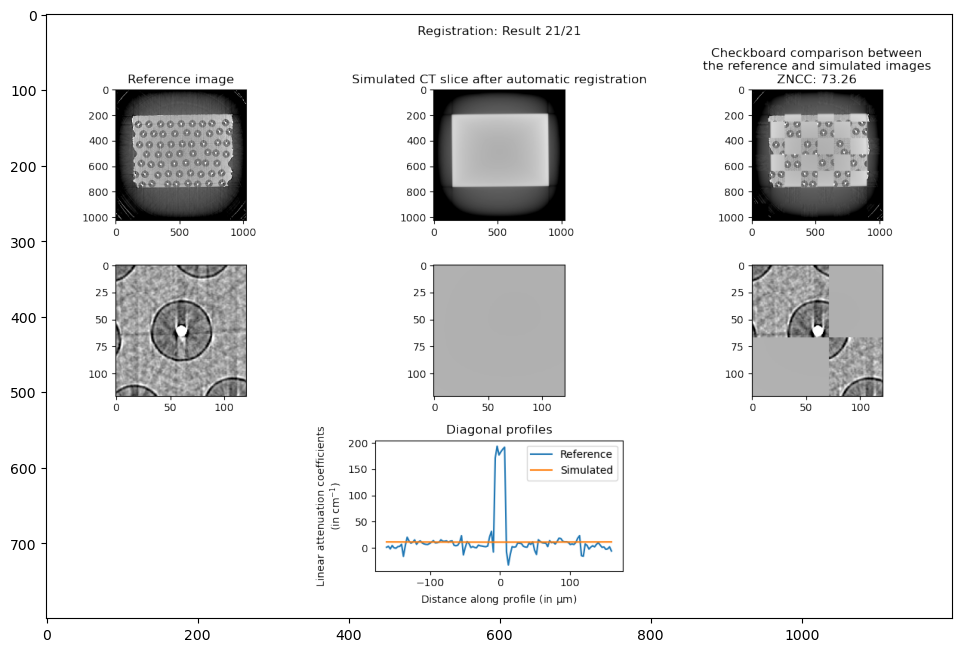

In [58]:
plt.imshow(image)

## Adding the fibres

The radius of a tungsten core is 30 / 2 um. The pixel spacing is 1.9 um. The radius in number of pixels is $15/1.9  \approx  7.89$. The area of a core is $(15/1.9)^2  \pi  \approx 196$ pixels.

In [59]:
setMatrix(matrix_geometry_parameters);
setFibres(centroid_set);

In [60]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

In [61]:
# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC matrix registration with fibres:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC matrix registration with fibres: 69.25


In [62]:
simulated_sinogram.shape     = (simulated_sinogram.size     // simulated_sinogram.shape[2],     simulated_sinogram.shape[2]);
normalised_projections.shape = (normalised_projections.size // normalised_projections.shape[2], normalised_projections.shape[2]);
raw_projections_in_keV.shape = (raw_projections_in_keV.size // raw_projections_in_keV.shape[2], raw_projections_in_keV.shape[2]);

saveMHA("outputs/simulated_sinogram_with_fibres.mha",
        simulated_sinogram,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

saveMHA("outputs/normalised_projections_with_fibres.mha",
        normalised_projections,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

saveMHA("outputs/raw_projections_in_keV_with_fibres.mha",
        raw_projections_in_keV,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

In [63]:
saveMHA("outputs/simulated_CT_with_fibres.mha",
        simulated_CT,
        [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

saveMHA("outputs/normalised_simulated_CT_with_fibres.mha",
        normalised_simulated_CT,
        [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

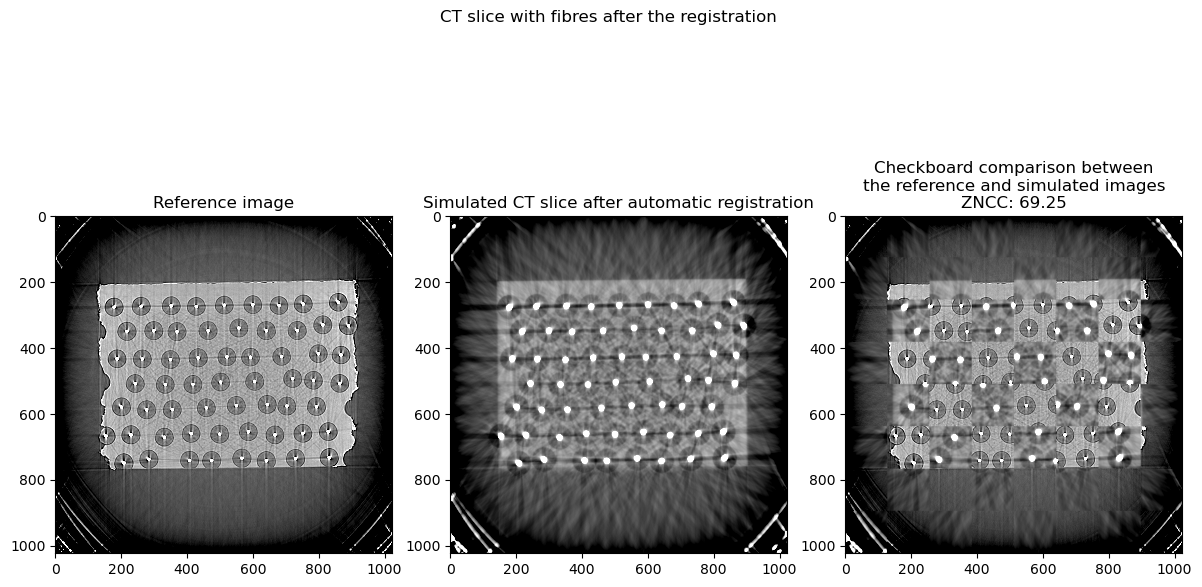

In [64]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.pdf');
plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.png');

# Optimisation of the cores and fibres radii

The function below is the objective function used to optimise the radii of the cores and fibres.

In [65]:
def fitnessFunctionFibres(x):
    global best_fitness;
    global best_fitness_id;
    global fibre_radius;
    global core_radius;
    global prefix;

    # Get the radii
    fibre_radius = x[0];
    core_radius = fibre_radius * x[1];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        gvxr.saveSTLfile("core",  "outputs/" + prefix + str(best_fitness_id) + "_cores.stl");
        gvxr.saveSTLfile("fibre", "outputs/" + prefix + str(best_fitness_id) + "_fibres.stl");
        
        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [66]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre1_radii.dat"):
    temp = np.loadtxt("outputs/fibre1_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre1_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=826019, Wed Aug 11 17:09:53 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.133708698445436e-01 1.0e+00 7.09e-01  6e-01  6e-01 0:08.1
    2     12 3.884900300610271e-01 1.3e+00 7.12e-01  6e-01  7e-01 0:14.7
    3     18 3.505666956237065e-01 1.5e+00 8.88e-01  8e-01  1e+00 0:21.3
    4     24 1.908870801154281e-01 1.9e+00 9.15e-01  7e-01  1e+00 0:28.3
    5     30 4.094047797452126e-01 2.2e+00 8.09e-01  6e-01  1e+00 0:34.9
    6     36 2.178027339316914e-01 2.4e+00 6.54e-01  4e-01  8e-01 0:41.5
    7     42 2.848424211802671e-01 2.9e+00 5.46e-01  3e-01  7e-01 0:48.2
    9     54 2.081527321038656e-01 3.1e+00 5.26e-01  2e-01  7e-01 1:01.7
   11     66 1.993601513846019e-01 3.6e+00 3.82e-01  1e-01  4e-01 1:15.2
   13     78 2.509825026536547e-01 3.3e+00 2.79e-01  7e-02  2e-01 1:28.3
   15     90 2.086870907711814e-01 3.4e+00 1.96e-01  4e-02  1e-01 1:41.4
   17    102 2.042247123904917e-01 

In [67]:
if not os.path.exists("plots/fibre1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre1_simulated_CT_",
                'plots/fibre1_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [68]:
Image(url="plots/fibre1_registration.gif")

View the last frame

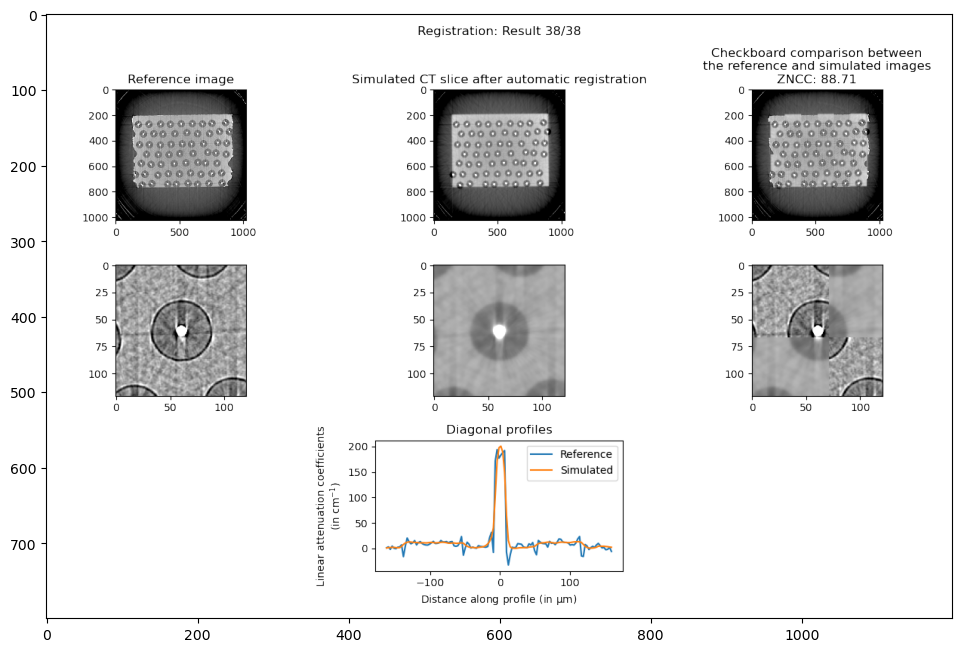

In [69]:
plt.imshow(image)

## Apply the result of the registration

In [70]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre1_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre1_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);


# Compute the ZNCC
print("ZNCC radii registration 1:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

Core diameter: 16 um
Fibre diameter: 103 um
ZNCC radii registration 1: 88.71


The 3D view of the registration looks like:

In [71]:
Image(url="./3d-view.png")

# Recentre each core/fibre

Each fibre is extracted from both the reference CT slice and simulated CT slice. The displacement between the corresponding fibres is computed to maximise the ZNCC between the two. The centre of the fibre is then adjusted accordingly.

In [72]:
def refineCentrePositions(centroid_set, reconstruction_CT_fibres):

    # Exhaustive local search to refine the centre of each cylinder
    roi_length = 40;
    new_centroid_set = [];
    for i, cyl in enumerate(centroid_set):

        centre = [
            cyl[0],
            cyl[1]
        ];

        # extract ROI from reference image
        reference_image = copy.deepcopy(reference_CT[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

        # Normalise ROI
        reference_image = standardisation(reference_image);

        best_ZNCC = -1;
        best_x_offset = 0;
        best_y_offset = 0;

        for y in range(-10, 11):
            for x in range(-10, 11):

                centre = [
                    cyl[0] + x,
                    cyl[1] + y
                ];

                # extract ROI from test image
                test_image = copy.deepcopy(reconstruction_CT_fibres[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

                # Normalise ROI
                test_image = standardisation(test_image);

                # Compare the ROIs
                zncc = np.mean(np.multiply(reference_image.flatten(), test_image.flatten()));

                if best_ZNCC < zncc:
                    best_ZNCC = zncc;
                    best_x_offset = x;
                    best_y_offset = y;

        # Correct the position of the centre of the fibre
        new_centroid_set.append([cyl[0] - best_x_offset, cyl[1] - best_y_offset]);

    return new_centroid_set;

In [73]:
centroid_set = refineCentrePositions(centroid_set, normalised_simulated_CT);

## Applying the result of recentring

In [74]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre2_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre2_core.stl");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC recentring registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC recentring registration: 89.36


# Optimisation the radii after recentring

After recentring the centres, another run of optimisation is executed to refine the radii of the fibres and cores.

In [75]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre3_radii.dat"):
    temp = np.loadtxt("outputs/fibre3_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre3_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre3_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=857651, Wed Aug 11 17:18:23 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.397162791772818e-01 1.0e+00 7.75e-01  6e-01  8e-01 0:08.2
    2     12 2.829841649034579e-01 1.2e+00 9.47e-01  6e-01  1e+00 0:14.9
    3     18 1.312412721152448e-01 2.0e+00 8.07e-01  5e-01  1e+00 0:21.9
    4     24 1.213296684608990e-01 2.1e+00 7.44e-01  5e-01  9e-01 0:29.1
    5     30 1.460846033036106e-01 2.0e+00 6.30e-01  3e-01  7e-01 0:35.8
    6     36 1.220726931919518e-01 2.1e+00 5.92e-01  3e-01  7e-01 0:42.4
    7     42 1.335337579037218e-01 2.7e+00 7.39e-01  3e-01  1e+00 0:49.0
    9     54 1.743395980441586e-01 4.5e+00 4.84e-01  1e-01  7e-01 1:02.2
   11     66 1.216276720300113e-01 4.8e+00 3.91e-01  1e-01  5e-01 1:15.3
   13     78 1.235513576922263e-01 6.9e+00 4.47e-01  7e-02  8e-01 1:28.5
   15     90 1.227070346213213e-01 1.7e+01 7.33e-01  9e-02  2e+00 1:41.7
   17    102 1.217109170133060e-01 

In [76]:
if not os.path.exists("plots/fibre3_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre3_simulated_CT_",
                'plots/fibre3_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [77]:
Image(url="plots/fibre3_registration.gif")

View the last frame

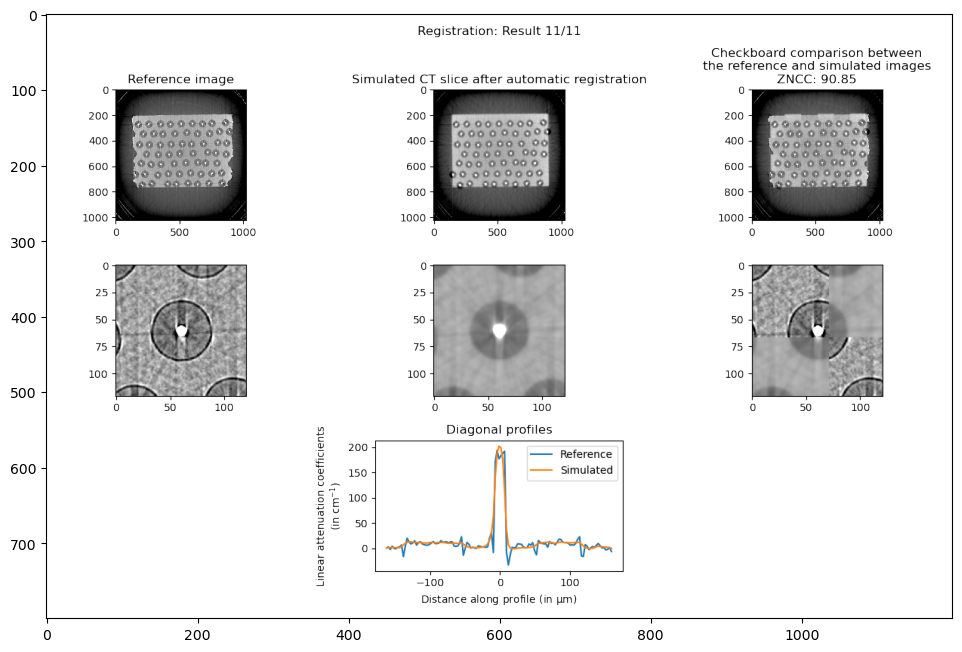

In [78]:
plt.imshow(image)

## Apply the result of the registration

In [79]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre3_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre3_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 16 um
Fibre diameter: 103 um


In [80]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC radii registration 2:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC radii registration 2: 90.85


# Optimisation of the beam spectrum

In [81]:
def fitnessHarmonics(x):

    global energy_spectrum;
    
    global use_normalisation;
    
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    energy_33_keV = x[0];
    first_order_harmonics = x[1];
    second_order_harmonics = x[2];

    # Normalise the beam spectrum
    total = energy_33_keV + first_order_harmonics + second_order_harmonics;
    energy_33_keV /= total;
    first_order_harmonics /= total;
    second_order_harmonics /= total;

    # The beam specturm. Here we have a polychromatic beam.
    gvxr.resetBeamSpectrum();
    energy_spectrum = [(33, energy_33_keV, "keV"), (66, first_order_harmonics, "keV"), (99, second_order_harmonics, "keV")];

    for energy, percentage, unit in energy_spectrum:
        gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

    # Compute the objective value (no normalisation here)
    old_normalisation = use_normalisation;
    use_normalisation = False;
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
    use_normalisation = old_normalisation;
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];

        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", np.array(x) / total, header='33keV,66keV,99keV');

        best_fitness_id += 1;

    return objective

In [82]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/spectrum1.dat"):
    temp = np.loadtxt("outputs/spectrum1.dat");

    # The beam specturm. Here we have a polychromatic beam.
    energy_spectrum = [(33, temp[0], "keV"), (66, temp[1], "keV"), (99, temp[2], "keV")];

# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [0.97, 0.2, 0.1];
    bounds = [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "spectrum1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessHarmonics);

    total = es.result.xbest[0] + es.result.xbest[1] + es.result.xbest[2];
    energy_spectrum = [(33, es.result.xbest[0] / total, "keV"), (66, es.result.xbest[1] / total, "keV"), (99, es.result.xbest[2] / total, "keV")];

    np.savetxt("outputs/spectrum1.dat", [es.result.xbest[0] / total, es.result.xbest[1] / total, es.result.xbest[2] / total], header='weight of main energy,weight of first order harmonics,weight of second order harmonics');
    
    # Release memory
    del es;

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=804237, Wed Aug 11 17:22:50 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 2.657445985885815e+03 1.0e+00 2.36e-01  2e-01  2e-01 0:09.2
    2     14 1.547085602295766e+03 1.3e+00 1.90e-01  2e-01  2e-01 0:17.4
    3     21 7.753806764553844e+02 1.5e+00 1.70e-01  1e-01  2e-01 0:25.2
    4     28 4.871960904937286e+02 1.5e+00 1.83e-01  1e-01  2e-01 0:33.4
    5     35 5.161828270010666e+02 1.8e+00 1.92e-01  1e-01  2e-01 0:40.9
    6     42 4.298763536256206e+02 1.8e+00 1.66e-01  1e-01  2e-01 0:48.8
    7     49 4.464960307268555e+02 1.7e+00 1.48e-01  7e-02  1e-01 0:56.3
    8     56 4.208880062347967e+02 2.0e+00 1.39e-01  6e-02  1e-01 1:04.1
   10     70 5.466637199902613e+02 2.6e+00 1.18e-01  5e-02  1e-01 1:19.2
   12     84 4.289769830325816e+02 3.1e+00 9.90e-02  4e-02  1e-01 1:33.8
   14     98 4.768015653782354e+02 4.3e+00 8.05e-02  3e-02  8e-02 1:48.7
   16    112 4.246221317070134e+02 

In [83]:
if not os.path.exists("plots/spectrum1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/spectrum1_simulated_CT_",
                'plots/spectrum1_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [84]:
Image(url="plots/spectrum1_registration.gif")

View the last frame

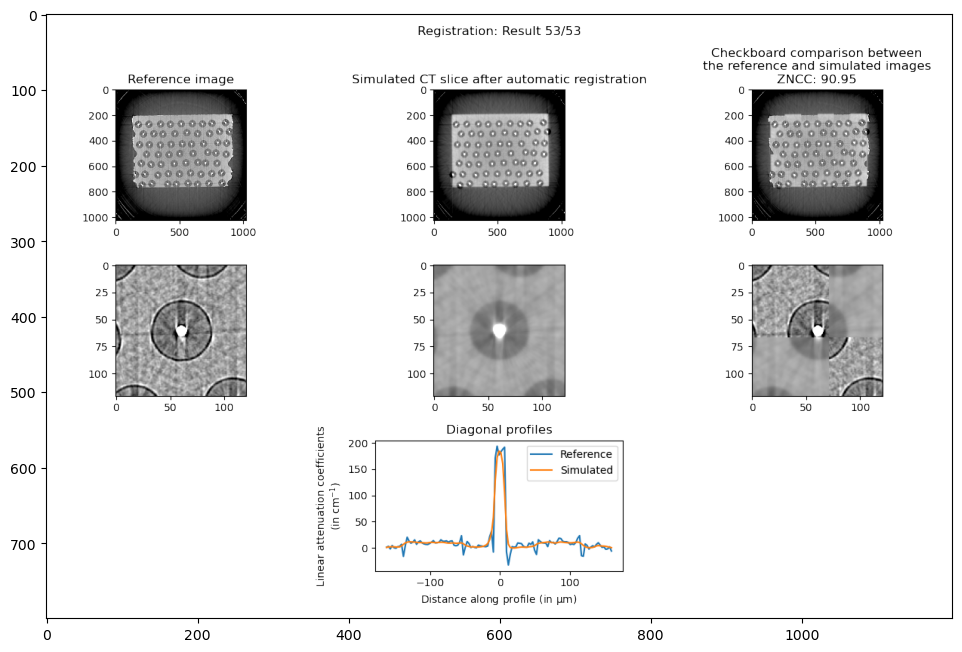

In [85]:
plt.imshow(image)

In [86]:
# Apply the result of the registration
gvxr.resetBeamSpectrum();
for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

In [87]:
for channel in energy_spectrum:
    print(channel);

(33, 0.962750170494123, 'keV')
(66, 0.0038501802571996205, 'keV')
(99, 0.0333996492486773, 'keV')


In [88]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC spectrum registration 1:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC spectrum registration 1: 90.95


# Optimisation of the phase contrast and the radii

In [89]:
def laplacian(x, sigma):
    """
    This function create a Laplacian kernel with

    $$ g''(x) = \left(\frac{x^2}{\sigma^4} - \frac{1}{\sigma^2}\right) \exp\left(-\frac{x^2}{2\sigma^2}\right) $$
    
    :param array x: 
    :param float sigma:
    :return the convolution kernel
    """
    
    return (np.power(x, 2.) / math.pow(sigma, 4) - 1. / math.pow(sigma, 2)) * np.exp(-np.power(x, 2.) / (2. * math.pow(sigma, 2)));

In [90]:
def getLBuffer(object):

    """
    This function compute the L-buffer of the object over all the angles
    
    :param str object: the name of the object 
    :return the L-buffer over all the angles
    """

    # An empty L-buffer
    L_buffer = [];

    # Get the line of L-buffer for each angle
    for angle_id in range(0, number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        line_of_L_buffer = np.array(gvxr.computeLBuffer(object));

        # Add the projection
        L_buffer.append(line_of_L_buffer);

    # Return as a numpy array
    return np.array(L_buffer);

In [91]:
def fitnessFunctionLaplacian(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global fibre_radius;
    global core_radius;

    sigma_core = x[0];
    k_core = x[1];
    sigma_fibre = x[2];
    k_fibre = x[3];
    sigma_matrix = x[4];
    k_matrix = x[5];
    core_radius = x[6];
    fibre_radius = x[7];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
                
        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];

        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');
    
        best_fitness_id += 1;

    return objective

In [92]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian1.dat"):
    temp = np.loadtxt("outputs/laplacian1.dat");
    sigma_core = temp[0];
    k_core = temp[1];
    sigma_fibre = temp[2];
    k_fibre = temp[3];
    sigma_matrix = temp[4];
    k_matrix = temp[5];
    core_radius = temp[6];
    fibre_radius = temp[7];

# Perform the registration using CMA-ES
else:

    sigma_core = 5.;
    sigma_fibre = 0.75;
    sigma_matrix = 0.6;

    k_core = 1000;
    k_fibre = 1000;
    k_matrix = 1000.0;

    x0 = [
        sigma_core, k_core, 
        sigma_fibre, k_fibre, 
        sigma_matrix, k_matrix, 
        core_radius, fibre_radius
    ];
    
    bounds = [
        [
            0.005, 0.0, 
             0.005, 0.0, 
             0.005, 0.0, 
             0.95 * core_radius, 0.95 * fibre_radius
        ],
        [
            10.0, 2000, 
             2.5, 2000, 
             2.5, 2000, 
             1.15 * core_radius, 1.15 * fibre_radius
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian1_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [0.25, 20.25, 0.25, 20.25, 0.25, 20.25, core_radius * 0.1, fibre_radius * 0.1];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacian);

    sigma_core = es.result.xbest[0];
    k_core = es.result.xbest[1];
    sigma_fibre = es.result.xbest[2];
    k_fibre = es.result.xbest[3];
    sigma_matrix = es.result.xbest[4];
    k_matrix = es.result.xbest[5];
    core_radius = es.result.xbest[6];
    fibre_radius = es.result.xbest[7];

    np.savetxt("outputs/laplacian1.dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');
    
    # Release memory
    del es;

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=818251, Wed Aug 11 17:34:52 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.128627785320182e-01 1.0e+00 2.44e-01  6e-02  5e+00 0:22.4
    2     20 1.127577655634415e-01 1.2e+00 2.46e-01  6e-02  5e+00 0:45.2
    3     30 1.117705289072551e-01 1.4e+00 2.37e-01  6e-02  5e+00 1:08.2
    4     40 1.110767877201964e-01 1.5e+00 2.14e-01  5e-02  4e+00 1:30.5
    5     50 1.110032970112093e-01 1.5e+00 2.05e-01  5e-02  4e+00 1:53.1
    6     60 1.109513954554905e-01 1.5e+00 2.01e-01  4e-02  4e+00 2:16.4
    7     70 1.109221935247666e-01 1.6e+00 2.05e-01  5e-02  4e+00 2:39.2
    8     80 1.109699000391871e-01 1.7e+00 2.01e-01  4e-02  4e+00 3:01.2
    9     90 1.110527898230884e-01 1.7e+00 2.06e-01  4e-02  4e+00 3:23.8
   10    100 1.110083670338569e-01 1.7e+00 2.23e-01  5e-02  5e+00 3:46.1
   11    110 1.112950586663904e-01 2.0e+00 2.15e-01  4e-02  4e+00 4:08.4
   12    120 1.110456851204059e-01

In [93]:
if not os.path.exists("plots/laplacian1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/laplacian1_simulated_CT_",
                'plots/laplacian1_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [94]:
Image(url="./plots/laplacian1_registration.gif")

View the last frame

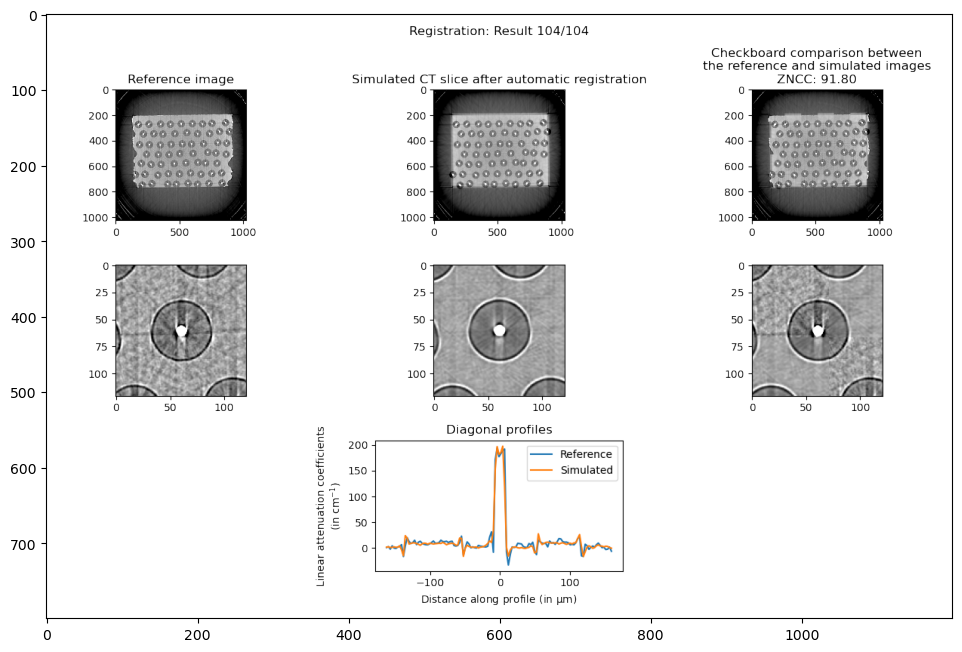

In [95]:
plt.imshow(image)

## Apply the result of the registration

In [96]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/laplacian1_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/laplacian1_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 16 um
Fibre diameter: 107 um


In [97]:
# Simulate the corresponding CT aquisition
sigma_set = [sigma_core, sigma_fibre, sigma_matrix];
k_set = [k_core, k_fibre, k_matrix]; 
label_set = ["core", "fibre", "matrix"];

simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC phase contrast registration 1:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC phase contrast registration 1: 93.18


# Optimisation of the phase contrast and the LSF

In [98]:
old_lsf = copy.deepcopy(lsf_kernel);

In [99]:
def fitnessFunctionLaplacianLSF(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global lsf_kernel;

    # sigma_core = x[0];
    k_core = x[0];
    # sigma_fibre = x[2];
    k_fibre = x[1];
    # sigma_matrix = x[4];
    k_matrix = x[2];

    b2 = x[3];
    c2 = x[4];
    e2 = x[5];
    f2 = x[6];

    # The response of the detector as the line-spread function (LSF)
    t = np.arange(-20., 21., 1.);
    lsf_kernel=lsf(t*41, b2, c2, e2, f2);
    lsf_kernel/=lsf_kernel.sum();

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + "laplacian_" + str(best_fitness_id) + ".dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
        np.savetxt("outputs/" + prefix + "LSF_" + str(best_fitness_id) + ".dat", [b2, c2, e2, f2], header='b2, c2, e2, f2');

        
        best_fitness_id += 1;

    return objective;

In [100]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian2.dat") and os.path.isfile("outputs/lsf2.dat"):
    temp = np.loadtxt("outputs/laplacian2.dat");
    k_core = temp[0];
    k_fibre = temp[1];
    k_matrix = temp[2];

    temp = np.loadtxt("outputs/lsf2.dat");
    b2 = temp[0];
    c2 = temp[1];
    e2 = temp[2];
    f2 = temp[3];

# Perform the registration using CMA-ES
else:

    b2 = 54.9359;
    c2 = -3.58452;
    e2 = 6.32561e+09;
    f2 = 1.0;

    x0 = [
        k_core,
        k_fibre,
        k_matrix,
        b2, c2, e2, f2
    ];

    bounds = [
        [
            k_core-500,
            k_fibre-500,
            k_matrix-500,
            b2 - b2 / 4.,
            c2 + c2 / 4.,
            e2 - e2 / 4.,
            f2 - f2/ 4.
        ],
        [
            k_core+500,
            k_fibre+500,
            k_matrix+500,
            b2 + b2 / 4.,
            c2 - c2 / 4.,
            e2 + e2 / 4.,
            f2 + f2/ 4.
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian2_"

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    #opts['seed'] = 987654321;
    # opts['maxiter'] = 5;
    opts['CMA_stds'] = [1250 * 0.2, 1250 * 0.2, 1250 * 0.2,
        b2 * 0.2, -c2 * 0.2, e2 * 0.2, f2 * 0.2];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacianLSF);

    k_core = es.result.xbest[0];
    k_fibre = es.result.xbest[1];
    k_matrix = es.result.xbest[2];

    b2 = es.result.xbest[3];
    c2 = es.result.xbest[4];
    e2 = es.result.xbest[5];
    f2 = es.result.xbest[6];

    np.savetxt("outputs/laplacian2.dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
    np.savetxt("outputs/lsf2.dat", [b2, c2, e2, f2], header='b2, c2, e2, f2');
    
    # Release memory
    del es;

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=739029, Wed Aug 11 18:23:07 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.065718826341313e-01 1.0e+00 2.19e-01  4e-02  3e+08 0:11.1
    2     18 1.065347508428139e-01 1.2e+00 2.07e-01  4e-02  2e+08 0:21.9
    3     27 1.062627385578101e-01 1.3e+00 1.99e-01  4e-02  2e+08 0:32.7
    4     36 1.061839301954330e-01 1.4e+00 1.98e-01  4e-02  2e+08 0:43.5
    5     45 1.060179154615556e-01 1.5e+00 2.00e-01  4e-02  2e+08 0:54.0
    6     54 1.061024402607409e-01 1.6e+00 1.84e-01  4e-02  2e+08 1:04.1
    7     63 1.061278422545926e-01 1.7e+00 1.71e-01  4e-02  2e+08 1:14.4
    8     72 1.059865839821377e-01 1.7e+00 1.59e-01  4e-02  2e+08 1:25.2
    9     81 1.059098690799496e-01 1.8e+00 1.61e-01  4e-02  2e+08 1:35.8
   10     90 1.058751838664796e-01 1.8e+00 1.85e-01  5e-02  2e+08 1:46.6
   11     99 1.057957056064688e-01 2.2e+00 2.12e-01  6e-02  2e+08 1:57.7
   13    117 1.058362531632262e-01 

In [101]:
if not os.path.exists("plots/laplacian2_registration.gif"):
    registration_image_set, image = createAnimation("outputs/laplacian2_simulated_CT_",
                'plots/laplacian2_registration.gif');

View the GIF animation (no preview on GitHub .ipynb files)

In [102]:
Image(url="plots/laplacian2_registration.gif")

View the last frame

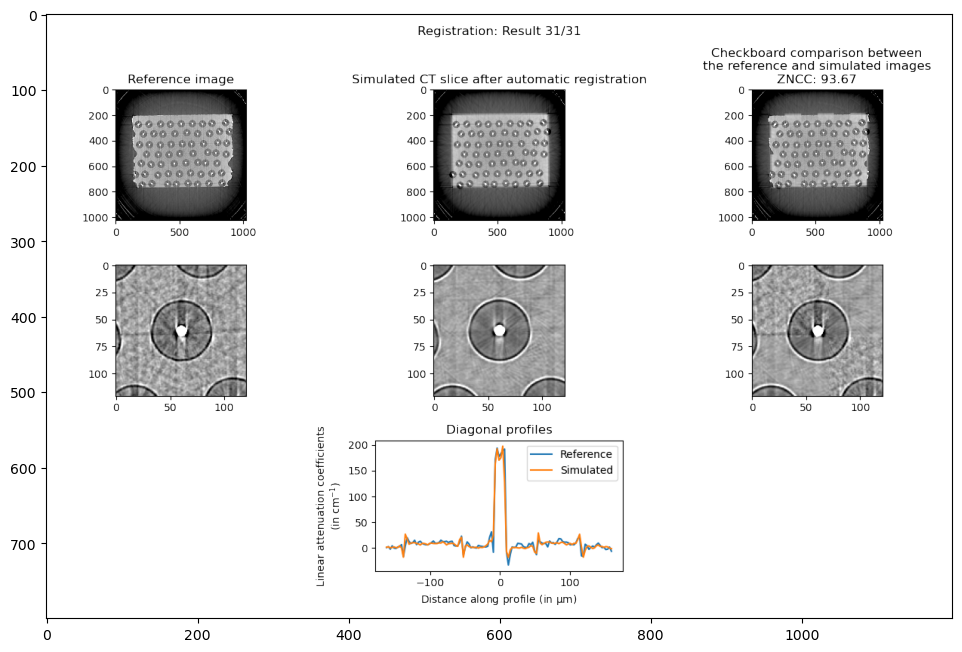

In [103]:
plt.imshow(image)

## Apply the result of the registration

In [104]:
# The response of the detector as the line-spread function (LSF)
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41, b2, c2, e2, f2);
lsf_kernel/=lsf_kernel.sum();
np.savetxt("outputs/LSF_optimised.txt", lsf_kernel);

In [105]:
# Simulate the corresponding CT aquisition
sigma_set = [sigma_core, sigma_fibre, sigma_matrix];
k_set = [k_core, k_fibre, k_matrix]; 
label_set = ["core", "fibre", "matrix"];

simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

offset1 = 86;
offset2 = reference_CT.shape[0] - offset1;
profile_test_whole_image_without_Poisson_noise = copy.deepcopy(np.diag(simulated_CT[offset1:offset2, offset1:offset2]));

# Compute the ZNCC
print("ZNCC phase contrast and LSF registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC phase contrast and LSF registration: 93.67


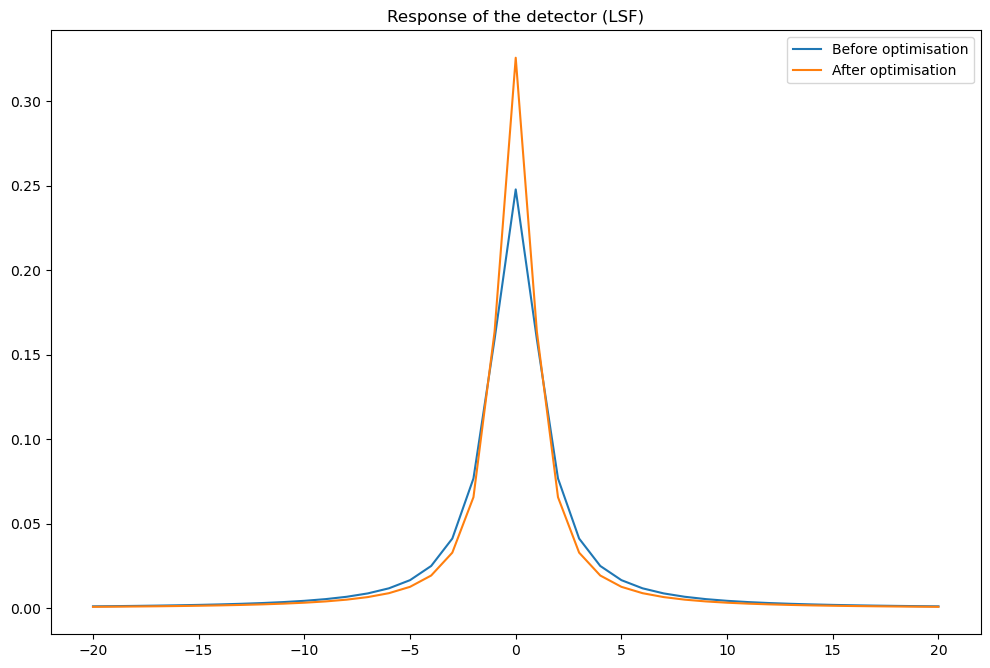

In [106]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, old_lsf, label="Before optimisation");
plt.plot(t, lsf_kernel, label="After optimisation");
plt.legend();
plt.savefig('plots/LSF_optimised.pdf');
plt.savefig('plots/LSF_optimised.png');

## Extract the fibre in the centre of the CT slices

In [107]:
def findFibreInCentreOfCtSlice():
    global centroid_set;
    global reference_CT;
    global cylinder_position_in_centre_of_slice;

    # Find the cylinder in the centre of the image
    cylinder_position_in_centre_of_slice = None;
    best_distance = sys.float_info.max;

    for centre in centroid_set:
        distance = math.pow(centre[0] - reference_CT.shape[1] / 2,2 ) + math.pow(centre[1] - reference_CT.shape[0] / 2, 2);

        if best_distance > distance:
            best_distance = distance;
            cylinder_position_in_centre_of_slice = copy.deepcopy(centre);

    return cylinder_position_in_centre_of_slice;

In [108]:
findFibreInCentreOfCtSlice();

reference_fibre_in_centre = np.array(copy.deepcopy(reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre      = np.array(copy.deepcopy(simulated_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

profile_reference = copy.deepcopy(np.diag(reference_fibre_in_centre));
profile_test_without_Poisson_noise = copy.deepcopy(np.diag(test_fibre_in_centre));

reference_fibre_in_centre = standardisation(reference_fibre_in_centre);
test_fibre_in_centre = standardisation(test_fibre_in_centre);

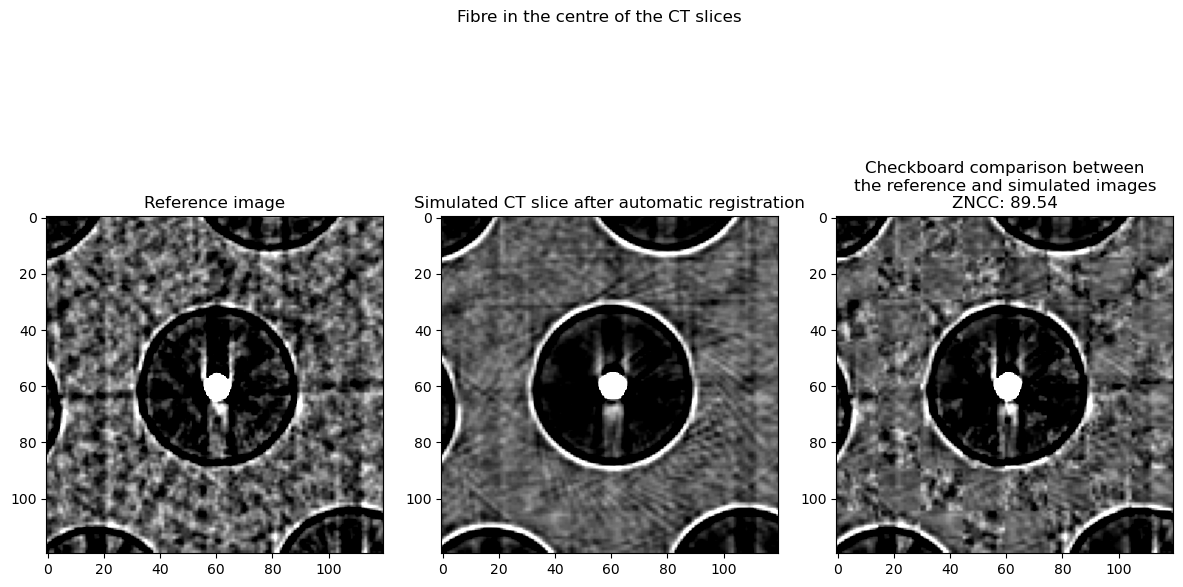

In [109]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Fibre in the centre of the CT slices')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(reference_fibre_in_centre, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(test_fibre_in_centre,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(reference_fibre_in_centre, test_fibre_in_centre, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(reference_fibre_in_centre, test_fibre_in_centre))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/Fibre_in_centre_CT_slices_before_noise.pdf');
plt.savefig('plots/Fibre_in_centre_CT_slices_before_noise.png');

# Optimisation of the Poisson noise

In [110]:
def fitnessFunctionNoise(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    bias = x[0];
    gain = x[1];
    scale = x[2];

    # Poisson noise
    map = (normalised_projections_ROI + (bias + 1)) * gain;
    temp = np.random.poisson(map).astype(float);
    temp /= gain;
    temp -= bias + 1;
    
    # Noise map
    noise_map = normalised_projections_ROI - temp;
    noise_map *= scale;
    noisy_image = normalised_projections_ROI + noise_map;

    # Compute the standard deviation of the pixel values in the ROI extracted from the simulated image with noise
    noisy_image_noise_ROI_stddev = 0;
    for y in range(noisy_image.shape[0]):
        noisy_image_noise_ROI_stddev += noisy_image[y].std();
    noisy_image_noise_ROI_stddev /= noisy_image.shape[0];

    # Difference of std dev between the reference and the simulated image
    diff = reference_noise_ROI_stddev - noisy_image_noise_ROI_stddev;
    objective = diff * diff;
    
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
    
        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "noisy_image_" + str(best_fitness_id) + ".mha",
                noisy_image,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [bias, gain, scale], header='bias, gain, scale');
        
        best_fitness_id += 1;

    return objective

In [111]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/poisson-noise.dat"):
    temp = np.loadtxt("outputs/poisson-noise.dat");
    bias = temp[0];
    gain = temp[1];
    scale = temp[2];

# Perform the registration using CMA-ES
else:

    # Extract a ROI from the reference where no object is
    reference_noise_ROI = copy.deepcopy(reference_normalised_projections[450:550,0:125]);

    saveMHA("outputs/reference_noise_ROI.mha",
           reference_noise_ROI,
           [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

    # Compute the standard deviation of the pixel values in the ROI extracted from the reference
    reference_noise_ROI_stddev = 0;
    for y in range(reference_noise_ROI.shape[0]):
        reference_noise_ROI_stddev += reference_noise_ROI[y].std();
    reference_noise_ROI_stddev /= reference_noise_ROI.shape[0];

    # Copy the simulated projection in a temporary variable
    temp = copy.deepcopy(normalised_projections);
    temp.shape = reference_normalised_projections.shape

    # Extract the corresponding ROI
    normalised_projections_ROI = temp[450:550,0:125];

    saveMHA("outputs/normalised_projections_ROI.mha",
           normalised_projections_ROI,
           [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
    
    # Initialise the values
    bias = 0.0;
    gain = 255.0;
    scale = 1;

    x0 = [bias, gain, scale];

    bounds = [
        [-1.0,   0.0, 0.0],
        [ 5.0, 255.0, 255.0]
    ];

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-8);
    opts['tolx'] = 1e-8;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [1, 10, 10];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "poisson-noise_";

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionNoise);

    bias = es.result.xbest[0];
    gain = es.result.xbest[1];
    scale = es.result.xbest[2];

    np.savetxt("outputs/poisson-noise.dat", [bias, gain, scale], header='bias, gain, scale');
    
    # Release memory
    del es;

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=857594, Wed Aug 11 18:32:35 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 2.982920191919707e-06 1.0e+00 2.24e-01  2e-01  2e+00 0:00.0
    2     14 6.353849645182939e-04 1.3e+00 2.07e-01  2e-01  2e+00 0:00.0
    3     21 1.233589661382649e-03 1.3e+00 2.32e-01  2e-01  2e+00 0:00.1
   71    497 1.379917233179754e-12 1.2e+03 3.72e-02  9e-04  3e-01 0:01.2


In [112]:
print("Noise parameters: ", bias, gain, scale)

Noise parameters:  -0.9755832910752753 253.37403431706466 0.07949086560131374


## Apply the result of the optimisation

In [113]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(sigma_set, k_set, label_set);

In [114]:
# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);
profile_test_whole_image_with_Poisson_noise = copy.deepcopy(np.diag(simulated_CT[offset1:offset2, offset1:offset2]));

# Compute the ZNCC
print("ZNCC noise registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC noise registration: 93.02


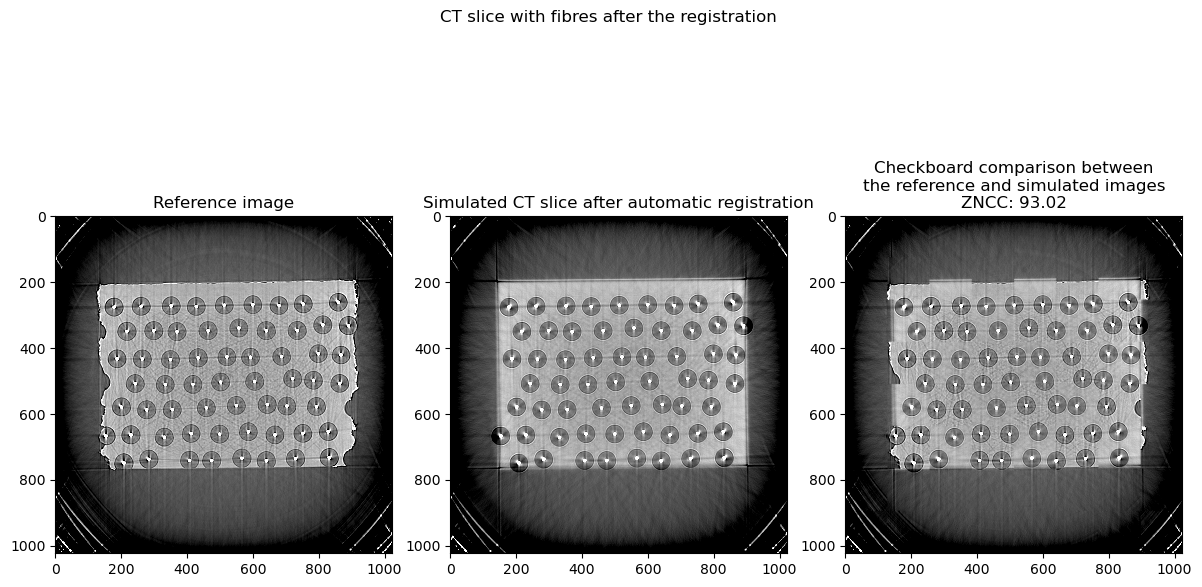

In [115]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/Fibre_in_centre_CT_slices_after_noise.pdf');
plt.savefig('plots/Fibre_in_centre_CT_slices_after_noise.png');

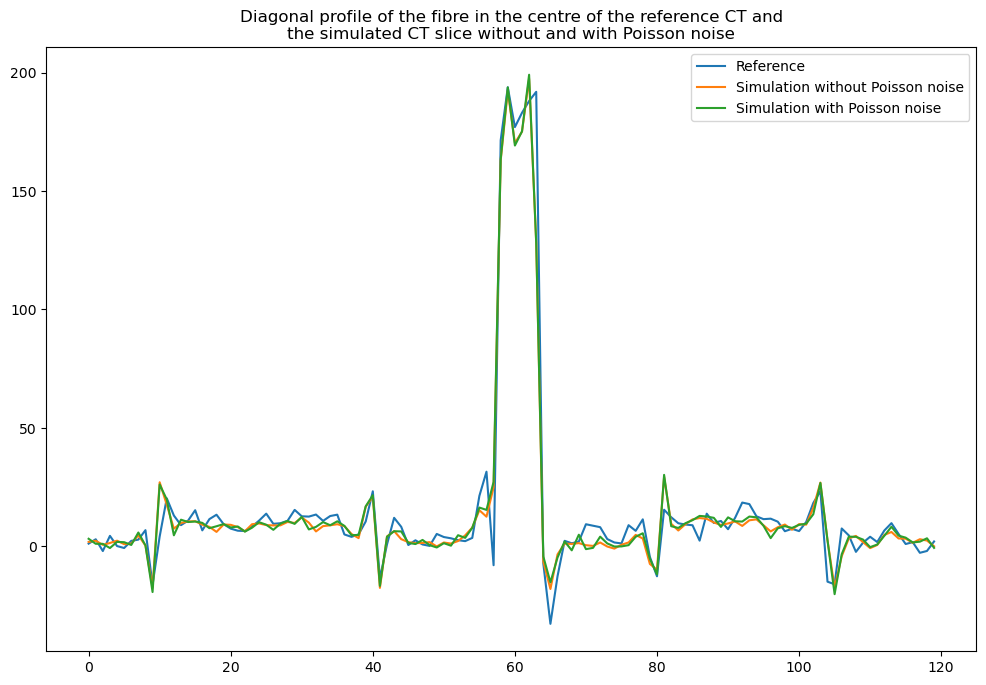

In [116]:
test_fibre_in_centre      = np.array(copy.deepcopy(simulated_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
profile_test_with_Poisson_noise = copy.deepcopy(np.diag(test_fibre_in_centre));

plt.figure()

plt.title("Diagonal profile of the fibre in the centre of the reference CT and\nthe simulated CT slice without and with Poisson noise")
plt.plot(profile_reference, label="Reference");
plt.plot(profile_test_without_Poisson_noise, label="Simulation without Poisson noise");
plt.plot(profile_test_with_Poisson_noise, label="Simulation with Poisson noise");
plt.legend();

plt.savefig('plots/profiles.pdf');
plt.savefig('plots/profiles.png');

# Results in terms of linear attenuation coefficients

Reduce the ROI size to focus on a single fibre and its surrounding matrix

In [117]:
roi_length = 40

Extract the ROIs

In [118]:
reference_fibre_in_centre = np.array(copy.deepcopy(reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre = np.array(copy.deepcopy(simulated_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

Save the ROIs

In [119]:
saveMHA("outputs/reference_fibre_in_centre.mha", reference_fibre_in_centre, [pixel_spacing_in_mm, pixel_spacing_in_mm]);
saveMHA("outputs/test_fibre_in_centre.mha", test_fibre_in_centre, [pixel_spacing_in_mm, pixel_spacing_in_mm]);

A function to create a circular binary mask

In [120]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return np.array(mask, dtype=bool);

A function to create the binary masks for the core, fibre and matrix

In [121]:
def createMasks(mask_shape):
    fibre_radius_in_px = fibre_radius / pixel_spacing_in_micrometre
    core_radius_in_px = core_radius / pixel_spacing_in_micrometre

    core_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, core_radius_in_px);

    fibre_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, fibre_radius_in_px);
    matrix_mask = np.logical_not(fibre_mask);

    #fibre_mask = np.subtract(fibre_mask, core_mask);
    fibre_mask = np.bitwise_xor(fibre_mask, core_mask);

    #TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

    return core_mask, fibre_mask, matrix_mask

Create binary masks for the core, fibre and matrix

In [122]:
mask_shape = reference_fibre_in_centre.shape;
core_mask, fibre_mask, matrix_mask = createMasks(mask_shape);

core_mask = ndimage.binary_erosion(core_mask).astype(core_mask.dtype);

for i in range(4):
    fibre_mask = ndimage.binary_erosion(fibre_mask).astype(fibre_mask.dtype);
    matrix_mask = ndimage.binary_erosion(matrix_mask, border_value=1).astype(matrix_mask.dtype);

core_mask.shape = [core_mask.shape[0], core_mask.shape[1]]
fibre_mask.shape = [fibre_mask.shape[0], fibre_mask.shape[1]]
matrix_mask.shape = [matrix_mask.shape[0], matrix_mask.shape[1]]


Save the binary masks

In [123]:
saveMHA("outputs/core_mask.mha", core_mask.astype(np.uint8), [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);
saveMHA("outputs/fibre_mask.mha", fibre_mask.astype(np.uint8), [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);
saveMHA("outputs/matrix_mask.mha", matrix_mask.astype(np.uint8), [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

Display the masks

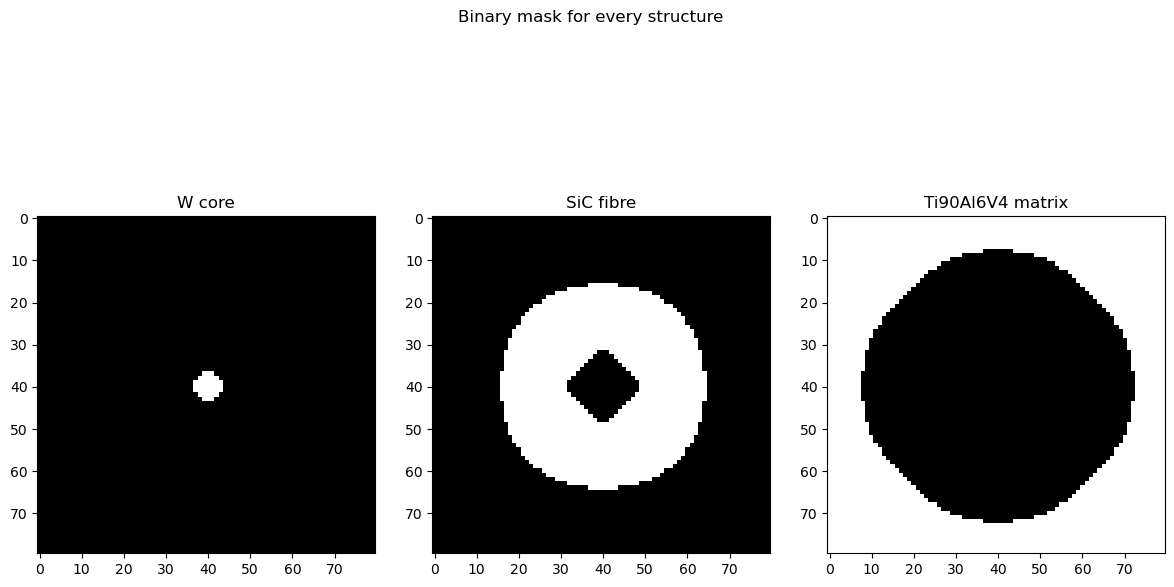

In [124]:
norm = cm.colors.Normalize(vmax=1, vmin=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Binary mask for every structure')

ax1.set_title("W core");
imgplot1 = ax1.imshow(core_mask, cmap="gray", 
                     norm=norm);

ax2.set_title("SiC fibre");
imgplot2 = ax2.imshow(fibre_mask,
                     cmap='gray',
                     norm=norm);

ax3.set_title("Ti90Al6V4 matrix");
imgplot3 = ax3.imshow(matrix_mask,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/masks.pdf');
plt.savefig('plots/masks.png');

A function to collect all the $\mu$ statistics from the masks.

In [125]:
def getMuStatistics(reference_fibre_in_centre, test_fibre_in_centre, core_mask, fibre_mask, matrix_mask):

    data = [];
    index = np.nonzero(core_mask);
    
    data.append(["Theorical", 
                "Core", 
                "W", 
                341.61,
                341.61,
                341.61,
                0.0]);

    data.append(["Experimental", 
                "Core", 
                "W", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index])]);
    
    data.append(["Simulated", 
                "Core", 
                "W", 
                np.min(test_fibre_in_centre[index]),
                np.max(test_fibre_in_centre[index]),
                np.mean(test_fibre_in_centre[index]),
                np.std(test_fibre_in_centre[index])]);

    index = np.nonzero(fibre_mask);

    data.append(["Theorical", 
                "Fibre", 
                "SiC", 
                2.736,
                2.736,
                2.736,
                0.0]);
    
    data.append(["Experimental", 
                "Fibre", 
                "SiC", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index])]);
    
    data.append(["Simulated", 
                "Fibre", 
                "SiC", 
                np.min(test_fibre_in_centre[index]),
                np.max(test_fibre_in_centre[index]),
                np.mean(test_fibre_in_centre[index]),
                np.std(test_fibre_in_centre[index])]);

    index = np.nonzero(matrix_mask);
    data.append(["Theorical", 
                "Matrix", 
                "Ti90Al6V4", 
                13.1274,
                13.1274,
                13.1274,
                0.0]);

    data.append(["Experimental", 
                "Matrix", 
                "Ti90Al6V4", 
                np.min(reference_fibre_in_centre[index]),
                np.max(reference_fibre_in_centre[index]),
                np.mean(reference_fibre_in_centre[index]),
                np.std(reference_fibre_in_centre[index])]);
    
    data.append(["Simulated", 
                "Matrix", 
                "Ti90Al6V4", 
                np.min(test_fibre_in_centre[index]),
                np.max(test_fibre_in_centre[index]),
                np.mean(test_fibre_in_centre[index]),
                np.std(test_fibre_in_centre[index])]);
    
    return pd.DataFrame(data,
            index=None,
            columns=['CT', 'Structure', "Composition", 'min', 'max', 'mean', 'stddev'])

Get the dataframe with all the values and display it as a table

In [126]:
df = getMuStatistics(reference_fibre_in_centre, test_fibre_in_centre, core_mask, fibre_mask, matrix_mask);

display(df)

CT Structure Composition         min         max        mean  \
0     Theorical      Core           W  341.610000  341.610000  341.610000   
1  Experimental      Core           W  120.325165  212.735718  188.644455   
2     Simulated      Core           W  123.703079  207.287216  185.433456   
3     Theorical     Fibre         SiC    2.736000    2.736000    2.736000   
4  Experimental     Fibre         SiC  -32.709011   31.958403    3.217891   
5     Simulated     Fibre         SiC  -17.909393   21.187803    2.500488   
6     Theorical    Matrix   Ti90Al6V4   13.127400   13.127400   13.127400   
7  Experimental    Matrix   Ti90Al6V4   -3.869796   25.127810   10.856583   
8     Simulated    Matrix   Ti90Al6V4   -0.209934   18.534582    9.812553   

      stddev  
0   0.000000  
1  16.044945  
2  16.951956  
3   0.000000  
4   6.269166  
5   4.004930  
6   0.000000  
7   4.368093  
8   2.854526

# Save the CAD models and plot them in 3D

In [127]:
gvxr.saveSTLfile("fibre", "outputs/final_SiC_fibres.stl");
gvxr.saveSTLfile("core",  "outputs/final_W_cores.stl");
gvxr.saveSTLfile("matrix", "outputs/final_Ti90Al6V4_matrix.stl");

In [128]:
np.savetxt("outputs/centroids.dat", centroid_set);

Load the STL files

In [129]:
fibre_mesh = mesh.Mesh.from_file('outputs/final_SiC_fibres.stl')
core_mesh = mesh.Mesh.from_file('outputs/final_W_cores.stl')
matrix_mesh = mesh.Mesh.from_file('outputs/final_Ti90Al6V4_matrix.stl')

Create the k3d geometries

In [130]:
matrix_geometry = k3d.mesh(matrix_mesh.vectors.flatten(),
                          range(int(matrix_mesh.vectors.flatten().shape[0] / 3)),
                          color=0x7fc97f, 
                          wireframe=False, 
                          flat_shading=False,
                          name="Ti90Al6V4 Matrix",
                          opacity = 0.4)
    
fibres_geometry = k3d.mesh(fibre_mesh.vectors.flatten(),
                          range(int(fibre_mesh.vectors.flatten().shape[0] / 3)),
                          color=0xbeaed4, 
                          wireframe=False, 
                          flat_shading=False,
                          name="SiC Fibres",
                          opacity = 0.9)

cores_geometry = k3d.mesh(core_mesh.vectors.flatten(),
                         range(int(core_mesh.vectors.flatten().shape[0] / 3)),
                         color=0xfdc086, 
                         wireframe=False, 
                         flat_shading=False,
                         name="W Cores",
                          opacity = 0.4)

Create a new plot

In [131]:
plot = k3d.plot()
plot.background_color = 0xffffff

plot += matrix_geometry
plot += fibres_geometry
plot += cores_geometry

plot.display()

Output()

Get a screenshot

In [132]:
plot.fetch_screenshot()

data = base64.b64decode(plot.screenshot)
with open('outputs/CAD_models_3d.png','wb') as fp:
    fp.write(data)

Save the figure

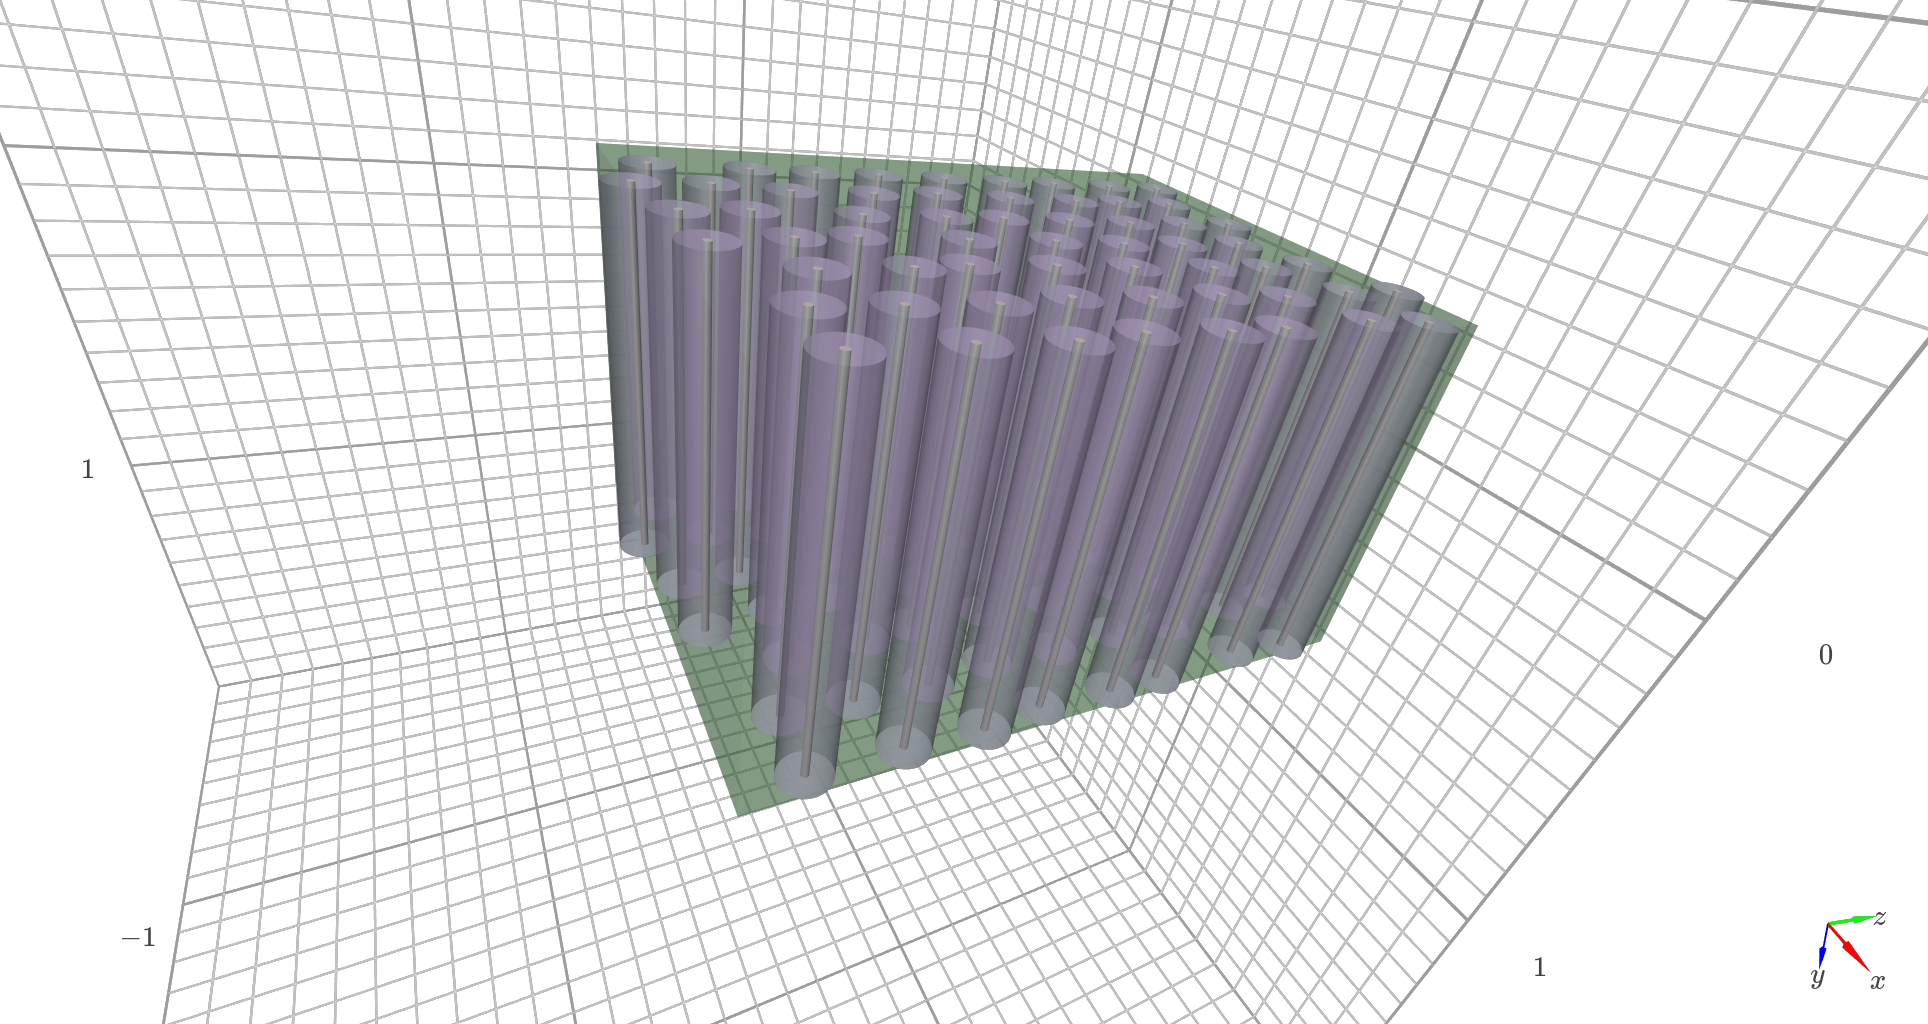

In [133]:
Image(filename='outputs/CAD_models_3d.png')